In [1]:
# !pip install spacy
# !pip install networkx
# !pip install tensorflow
# !pip install tensorflow-datasets

<img src="https://github.com/djp840/MSDS_453_Public/blob/main/images/NorthwesternHeader.png?raw=1">

## MSDS453 - Research Assignment 03 - Ontology Plus Context and Modeling

Take the ontology that you developed in week 6 and consider how your ten chosen documents for this quarter's class corpus map to that ontology.

Protégé is a tool that takes inputs for a human-created Ontology and creates a visualization. 

Use Python algorithms to generate Knowledge Graphs from your documents.

TensorFlow Bidirectional RNN Model

In [2]:
import pandas as pd
import numpy as np
import re
import string
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from collections import Counter
from dataclasses import dataclass
from timeit import default_timer as timer

from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize 

import gensim
from gensim.models import Word2Vec

import spacy
from spacy import displacy

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split

from IPython.display import display, HTML

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, f1_score

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
tf.random.set_seed(2022)

from typing import List, Callable, Dict, Tuple, Set

<div class="alert alert-block alert-danger">
<b>Required Installation: en_core_web_lg</b><br>"python -m spacy download en_core_web_lg"<br><br>English pipeline optimized for CPU. Components: tok2vec, tagger, parser, senter, ner, attribute_ruler, lemmatizer<br>
    <b>https://spacy.io/models/en#en_core_web_lg </b>
</div>

## Requires Restart Of Runtime After Installation

In [3]:
#!python -m spacy download en_core_web_lg -q

In [4]:
nlp = spacy.load('en_core_web_lg')

### Mount Google Drive to Colab Environment

In [5]:
#from google.colab import drive
#drive.mount('/content/gdrive')

### NLTK Downloads

In [6]:
# Only run this once, they will be downloaded.
nltk.download('stopwords',quiet=True)
nltk.download('wordnet',quiet=True)
nltk.download('punkt',quiet=True)
nltk.download('omw-1.4',quiet=True)

True

<div class="alert alert-block alert-danger">
<b>Gensim</b> is a Python library for topic modelling, document indexing and similarity retrieval with large corpora. Target audience is the natural language processing (NLP) and information retrieval (IR) community <br><br>
    <b>https://pypi.org/project/gensim/ </b>
</div>

In [7]:
# import pkg_resources
# pkg_resources.require("gensim<=3.8.3");

In [8]:
print("Genism Version: ", gensim.__version__)

Genism Version:  3.8.3


<div class="alert alert-block alert-info">
    <b>Suppress warning messages</b></div>

In [9]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

## Data Wrangling Utility Functions

In [10]:
def add_movie_descriptor(data: pd.DataFrame, corpus_df: pd.DataFrame):
    """
    Adds "Movie Description" to the supplied dataframe, in the form {Genre}_{P|N}_{Movie Title}_{DocID}
    """
    review = np.where(corpus_df['Review Type (pos or neg)'] == 'Positive', 'P', 'N')
    data['Descriptor'] = corpus_df['Genre of Movie'] + '_' + corpus_df['Movie Title'] + '_' + review + '_' + corpus_df['Doc_ID'].astype(str)
    
def get_corpus_df(path: str) -> pd.DataFrame:
    data = pd.read_csv(path)
    add_movie_descriptor(data, data)
    sorted_data = data.sort_values(['Descriptor'])
    indexed_data = sorted_data.set_index(['Doc_ID'])
    indexed_data['Doc_ID'] = indexed_data.index
    return indexed_data

def remove_punctuation(text: str) -> str:
    return re.sub('[^a-zA-Z]', '', str(text))

def remove_tags(text: str) -> str:    
    return re.sub('&lt;/?.*?&gt;', '', text)

def remove_special_chars_and_digits(text: str) -> str:
    return re.sub('(\\d|\\W)+', '', text)

def get_sentences(text: str) -> List[str]:
    return [str(x) for x in nlp(text).sents]

def get_coref_resolved_sentences(text: str) -> List[str]:
    return [str(x) for x in nlp(text).sents]

def get_lemmas(text: str, stopwords: Set[str]) -> List[str]:
    initial = [remove_tags(remove_special_chars_and_digits(remove_punctuation(x.lemma_.lower()))) for x in nlp(text)]
    return [x for x in initial if x not in stopwords]

def lemmatize_sentence(text: str, stopwords: Set[str]) -> str:
    return ' '.join(get_lemmas(text, stopwords))

def clean_doc(doc): 
    #doc = remove_punctuation(doc)
    doc= ' '.join(remove_stop_words(doc))
    doc = apply_lemmatization(doc)
    return doc

def remove_stop_words(in_text):
    stop_words = set(stopwords.words('english')) 
    word_tokens = word_tokenize(in_text)  
    filtered_sentence = [w for w in word_tokens if not w in stop_words] 
    return filtered_sentence

def apply_lemmatization(in_text):
    # Lemmatization
    lem = WordNetLemmatizer()
    word_list = nltk.word_tokenize(in_text)
    output = ' '.join([lem.lemmatize(w) for w in word_list])
    return output

def counter_word(text):
  count=Counter()
  for i in text.values:
    for word in i.split():
      count[word]=+1
  return count

## Knowledge Context Graph Functions

In [11]:
def map_edges(map_to: str, map_from: Set[str], df: pd.DataFrame):
    print(f'Before mapping {", ".join(map_from)} -> {map_to}: {sum(df.edge == map_to)}')
    df['edge'] = np.where(kg_df.edge.isin(map_from), map_to, kg_df.edge)
    print(f'After mapping {", ".join(map_from)} -> {map_to}: {sum(df.edge == map_to)}')
    
def map_sources_and_targets(map_to: str, map_from: Set[str], df: pd.DataFrame):
    before = sum(df.source == map_to) + sum(df.target == map_to)
    print(f'Before mapping {", ".join(map_from)} -> {map_to}: {before}')
    
    df['source'] = np.where(kg_df.source.isin(map_from), map_to, kg_df.source)
    df['target'] = np.where(kg_df.target.isin(map_from), map_to, kg_df.target)
    
    after = sum(df.source == map_to) + sum(df.target == map_to)
    print(f'After mapping {", ".join(map_from)} -> {map_to}: {after}')
    
def get_neighborhood(sources: Set[str], edge_types: Set[str], depth: int, df: pd.DataFrame) -> pd.DataFrame:
    output = []
    
    for d in range(depth):
        if edge_types is not None:
            rows = df[(df.edge.isin(edge_types)) & ((df.source.isin(sources)) | (df.target.isin(sources)))].copy()
        else:
            rows = df[(df.source.isin(sources)) | (df.target.isin(sources))].copy()
            
        output.append(rows)
        sources = set(rows.target).union(set(rows.source))
        
    return pd.concat(output).drop_duplicates()

def find_sources_and_targets_with_patterns(patterns: List[str], df: pd.DataFrame):
    mask = np.zeros(kg_df.shape[0])
    for pattern in patterns:
        mask = mask | (df.source.str.contains(pattern)) | (df.target.str.contains(pattern))
        
    return df[mask]
# Examples of how to use the function:
# find_sources_and_targets_with_patterns(['action'], kg_df)
# find_sources_and_targets_with_patterns(['terror'], kg_df)
# find_sources_and_targets_with_patterns(['novel'], kg_df)
# find_sources_and_targets_with_patterns(['director', 'campbell'], kg_df)


def plot_graph(df: pd.DataFrame, show_edges: bool = False, figsize: Tuple[int, int] = (12, 12), use_circular: bool=True):
    graph = nx.from_pandas_edgelist(df, "source", "target", edge_attr='edge', create_using=nx.MultiDiGraph())

    plt.figure(figsize=figsize)
    if use_circular:
        pos = nx.circular_layout(graph)
    else:
        pos = nx.kamada_kawai_layout(graph)
        
    nx.draw(graph, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos=pos)
    if show_edges:
        nx.draw_networkx_edge_labels(graph, pos=pos, font_size=8)
        
    plt.show()
    
def get_top_sources_and_targets(df: pd.DataFrame, top: int = 10):
    return (Counter(df.source) + Counter(df.target)).most_common(top)

def get_top_edges(df: pd.DataFrame, top: int = 10):
    return Counter(df.edge).most_common(top)

def get_dataset_partitions_pd(df, train_split=0.8, val_split=0.10, test_split=0.10):
       # Specify seed to always have the same split distribution between runs
    df_sample = df.sample(frac=1, random_state=12)
    indices_or_sections = [int(.8*len(df)), int(.9*len(df))]
    train_ds, val_ds, test_ds = np.split(df_sample, indices_or_sections)
    return train_ds, val_ds, test_ds

## Entity Extraction Functions

https://hami-asmai.medium.com/relationship-extraction-from-any-web-articles-using-spacy-and-jupyter-notebook-in-6-steps-4444ee68763f

In [12]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text

  return [ent1.strip(), ent2.strip()]

def get_relation(sent):
    try:
        doc = nlp(sent)
        
        # Matcher class object 
        matcher = Matcher(nlp.vocab)

        #define the pattern 
        pattern = [{'DEP':'ROOT'}, 
                {'DEP':'prep','OP':"?"},
                {'DEP':'agent','OP':"?"},  
                {'POS':'ADJ','OP':"?"}] 
        matcher.add("matching_1", [pattern]) 
        matches = matcher(doc)
        k = len(matches) - 1
        span = doc[matches[k][1]:matches[k][2]] 
        
        return(span.text)
    except:
        pass
    
def get_subject_verb_object(sent):
  ent1 = ""
  ent2 = ""
  root = ""

  for tok in nlp(sent):
      if tok.dep_ == 'ROOT':
        root = tok.text
      elif tok.dep_ == "nsubj":
        ent1 = tok.text
      elif tok.dep_ == "dobj":
        ent2 = tok.text

      if ent1 != '' and ent2 != '' and root != '':
        break

  return [ent1, root, ent2]

## Visualization Utility Functions

In [13]:
def plot_confusion_matrix_labeled(y_true, y_pred, CLASSES_LIST):
    mtx = confusion_matrix(y_true, y_pred)
    # define classes 
    classes = CLASSES_LIST
    temp_df = pd.DataFrame(data=mtx,columns=classes)
    temp_df.index = classes
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(temp_df, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')
    
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

## Loading the Class Corpus

In [14]:
CORPUS_PATH = 'ClassCorpus_Final_v5_20220717.csv'
corpus_df = get_corpus_df(CORPUS_PATH)

# remove those weird non ASCII chars
corpus_df['Text'] = corpus_df['Text'].apply(lambda x: ''.join([i if 32 < ord(i) < 126 else " " for i in x]))

## Exploratory Data Analysis

In [15]:
# Tokenize sentences
corpus_df['raw_sentences'] = corpus_df.Text.apply(get_sentences)
corpus_df.head(3).T

Doc_ID                                                                   40  \
DSI_Title                                           KCM_Doc1_AngelHasFallen   
Text                      Boredom sets in long before the start of Angel...   
Submission File Name                                KCM_Doc1_AngelHasFallen   
Student Name                                                            KCM   
Genre of Movie                                                       Action   
Review Type (pos or neg)                                           Negative   
Movie Title                                                Angel Has Fallen   
Descriptor                                     Action_Angel Has Fallen_N_40   
Doc_ID                                                                   40   
raw_sentences             [Boredom sets in long before the start of Ange...   

Doc_ID                                                                   41  \
DSI_Title                                           KCM_Doc2_AngelHasFallen   
Text                        Who ARE all these people?   That was what I ...   
Submission File Name                                KCM_Doc2_AngelHasFallen   
Student Name                                                            KCM   
Genre of Movie                                                       Action   
Review Type (pos or neg)                                           Negative   
Movie Title                                                Angel Has Fallen   
Descriptor                                     Action_Angel Has Fallen_N_41   
Doc_ID                                                                   41   
raw_sentences             [  Who ARE all these people?   , That was what...   

Doc_ID                                                                   42  
DSI_Title                                           KCM_Doc3_AngelHasFallen  
Text                      Ric Roman Waugh s Angel Has Fallen sees U.S. S...  
Submission File Name                                KCM_Doc3_AngelHasFallen  
Student Name                                                            KCM  
Genre of Movie                                                       Action  
Review Type (pos or neg)                                           Negative  
Movie Title                                                Angel Has Fallen  
Descriptor                                     Action_Angel Has Fallen_N_42  
Doc_ID                                                                   42  
raw_sentences             [Ric Roman Waugh s Angel Has Fallen sees U.S. ...

## Tokenize Words

In [16]:
default_stopwords=\
set(nltk.corpus.stopwords.words('english')).union(set(nlp.Defaults.stop_words)).union({' ', ''})
corpus_df['lemmas'] = corpus_df.Text.apply(lambda x: get_lemmas(x, default_stopwords))
corpus_df.lemmas.head()

Doc_ID
40    [boredom, set, long, start, angel, fallen, sta...
41    [people, mutter, enter, screening, angel, fall...
42    [ric, roman, waugh, angel, fallen, secret, ser...
43    [certain, mindless, pleasure, fallen, movie, w...
44    [need, olympus, fallen, andor, london, fallen,...
Name: lemmas, dtype: object

In [17]:
corpus_df.head(3).T

Doc_ID                                                                   40  \
DSI_Title                                           KCM_Doc1_AngelHasFallen   
Text                      Boredom sets in long before the start of Angel...   
Submission File Name                                KCM_Doc1_AngelHasFallen   
Student Name                                                            KCM   
Genre of Movie                                                       Action   
Review Type (pos or neg)                                           Negative   
Movie Title                                                Angel Has Fallen   
Descriptor                                     Action_Angel Has Fallen_N_40   
Doc_ID                                                                   40   
raw_sentences             [Boredom sets in long before the start of Ange...   
lemmas                    [boredom, set, long, start, angel, fallen, sta...   

Doc_ID                                                                   41  \
DSI_Title                                           KCM_Doc2_AngelHasFallen   
Text                        Who ARE all these people?   That was what I ...   
Submission File Name                                KCM_Doc2_AngelHasFallen   
Student Name                                                            KCM   
Genre of Movie                                                       Action   
Review Type (pos or neg)                                           Negative   
Movie Title                                                Angel Has Fallen   
Descriptor                                     Action_Angel Has Fallen_N_41   
Doc_ID                                                                   41   
raw_sentences             [  Who ARE all these people?   , That was what...   
lemmas                    [people, mutter, enter, screening, angel, fall...   

Doc_ID                                                                   42  
DSI_Title                                           KCM_Doc3_AngelHasFallen  
Text                      Ric Roman Waugh s Angel Has Fallen sees U.S. S...  
Submission File Name                                KCM_Doc3_AngelHasFallen  
Student Name                                                            KCM  
Genre of Movie                                                       Action  
Review Type (pos or neg)                                           Negative  
Movie Title                                                Angel Has Fallen  
Descriptor                                     Action_Angel Has Fallen_N_42  
Doc_ID                                                                   42  
raw_sentences             [Ric Roman Waugh s Angel Has Fallen sees U.S. ...  
lemmas                    [ric, roman, waugh, angel, fallen, secret, ser...

## Reassemble Leminized Words

In [18]:
corpus_df['lemmas_joined'] = corpus_df.lemmas.apply(lambda x: ' '.join(x))

In [19]:
corpus_df['lemmas_joined'].head()

Doc_ID
40    boredom set long start angel fallen start jour...
41    people mutter enter screening angel fallen loc...
42    ric roman waugh angel fallen secret service ag...
43    certain mindless pleasure fallen movie watch g...
44    need olympus fallen andor london fallen unders...
Name: lemmas_joined, dtype: object

In [20]:
corpus_df.head(3).T

Doc_ID                                                                   40  \
DSI_Title                                           KCM_Doc1_AngelHasFallen   
Text                      Boredom sets in long before the start of Angel...   
Submission File Name                                KCM_Doc1_AngelHasFallen   
Student Name                                                            KCM   
Genre of Movie                                                       Action   
Review Type (pos or neg)                                           Negative   
Movie Title                                                Angel Has Fallen   
Descriptor                                     Action_Angel Has Fallen_N_40   
Doc_ID                                                                   40   
raw_sentences             [Boredom sets in long before the start of Ange...   
lemmas                    [boredom, set, long, start, angel, fallen, sta...   
lemmas_joined             boredom set long start angel fallen start jour...   

Doc_ID                                                                   41  \
DSI_Title                                           KCM_Doc2_AngelHasFallen   
Text                        Who ARE all these people?   That was what I ...   
Submission File Name                                KCM_Doc2_AngelHasFallen   
Student Name                                                            KCM   
Genre of Movie                                                       Action   
Review Type (pos or neg)                                           Negative   
Movie Title                                                Angel Has Fallen   
Descriptor                                     Action_Angel Has Fallen_N_41   
Doc_ID                                                                   41   
raw_sentences             [  Who ARE all these people?   , That was what...   
lemmas                    [people, mutter, enter, screening, angel, fall...   
lemmas_joined             people mutter enter screening angel fallen loc...   

Doc_ID                                                                   42  
DSI_Title                                           KCM_Doc3_AngelHasFallen  
Text                      Ric Roman Waugh s Angel Has Fallen sees U.S. S...  
Submission File Name                                KCM_Doc3_AngelHasFallen  
Student Name                                                            KCM  
Genre of Movie                                                       Action  
Review Type (pos or neg)                                           Negative  
Movie Title                                                Angel Has Fallen  
Descriptor                                     Action_Angel Has Fallen_N_42  
Doc_ID                                                                   42  
raw_sentences             [Ric Roman Waugh s Angel Has Fallen sees U.S. ...  
lemmas                    [ric, roman, waugh, angel, fallen, secret, ser...  
lemmas_joined             ric roman waugh angel fallen secret service ag...

## Vocabulary Data Wrangling

In [21]:
vectorizer = CountVectorizer(ngram_range=(1, 1))
transformed_documents = vectorizer.fit_transform(corpus_df.lemmas_joined)
doc_term_matrix = transformed_documents.todense()
doc_term_df = pd.DataFrame(doc_term_matrix, 
                           columns=vectorizer.get_feature_names_out(), 
                           index=corpus_df.Descriptor)
print(f'All Word Vocabulary size: {doc_term_df.shape[1]}')
all_words = set(doc_term_df.columns)

# ignore terms that aren't within these frequencies
vectorizer = CountVectorizer(ngram_range=(1, 1), min_df=5, max_df=.8)
transformed_documents = vectorizer.fit_transform(corpus_df.lemmas_joined)
doc_term_matrix = transformed_documents.todense()
doc_term_df = pd.DataFrame(doc_term_matrix, 
                           columns=vectorizer.get_feature_names_out(), 
                           index=corpus_df.Descriptor)
print(f'Curated Vocabulary size: {doc_term_df.shape[1]}')
vocabulary = set(doc_term_df.columns)

words_to_remove = default_stopwords.union(all_words - vocabulary)

All Word Vocabulary size: 11765
Curated Vocabulary size: 2884


In [22]:
doc_term_df.head(5)

aaron  abandon  abduct  abigail  ability  able  \
Descriptor                                                                     
Action_Angel Has Fallen_N_40      0        0       0        0        0     0   
Action_Angel Has Fallen_N_41      0        0       0        0        0     0   
Action_Angel Has Fallen_N_42      0        1       0        0        0     0   
Action_Angel Has Fallen_N_43      0        0       0        0        0     0   
Action_Angel Has Fallen_N_44      0        0       0        0        0     1   

                              absence  absent  absolute  absolutely  ...  \
Descriptor                                                           ...   
Action_Angel Has Fallen_N_40        0       0         0           1  ...   
Action_Angel Has Fallen_N_41        0       0         0           0  ...   
Action_Angel Has Fallen_N_42        0       0         0           0  ...   
Action_Angel Has Fallen_N_43        0       0         0           0  ...   
Action_Angel Has Fallen_N_44        0       0         1           0  ...   

                              yell  yellow  yes  york  young  zac  zero  \
Descriptor                                                                
Action_Angel Has Fallen_N_40     0       0    0     0      0    0     0   
Action_Angel Has Fallen_N_41     0       0    0     0      0    0     0   
Action_Angel Has Fallen_N_42     0       0    0     0      0    0     0   
Action_Angel Has Fallen_N_43     0       0    0     0      1    0     0   
Action_Angel Has Fallen_N_44     0       0    0     0      0    0     0   

                              zombie  zone  zora  
Descriptor                                        
Action_Angel Has Fallen_N_40       0     0     0  
Action_Angel Has Fallen_N_41       0     0     0  
Action_Angel Has Fallen_N_42       0     0     0  
Action_Angel Has Fallen_N_43       0     0     0  
Action_Angel Has Fallen_N_44       0     0     0  

[5 rows x 2884 columns]

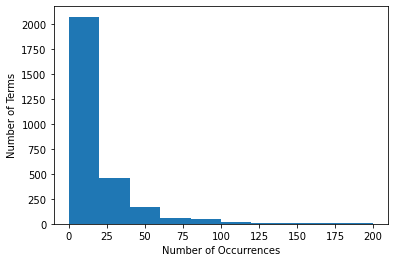

In [23]:
plt.hist(doc_term_df.sum(axis=0).T, range=(0, 200))
plt.xlabel('Number of Occurrences')
plt.ylabel('Number of Terms');

In [24]:
# Re-tokenize words, recreate joined documents
corpus_df['lemmas'] = corpus_df.Text.apply(lambda x: get_lemmas(x, words_to_remove))
corpus_df['lemmas_joined'] = corpus_df.lemmas.apply(lambda x: ' '.join(x))
corpus_df.lemmas.head()

Doc_ID
40    [set, long, start, angel, fallen, start, journ...
41    [people, enter, angel, fallen, local, cinema, ...
42    [ric, roman, waugh, angel, fallen, secret, ser...
43    [certain, pleasure, fallen, watch, gerard, but...
44    [need, olympus, fallen, andor, london, fallen,...
Name: lemmas, dtype: object

## Get Lemmatized and Filtered Sentences

Removes the additional words 

In [25]:
corpus_df['sentences_lemmatized']=\
corpus_df.raw_sentences.apply(lambda x: [lemmatize_sentence(s, words_to_remove) for s in x])

In [26]:
corpus_df.head().T

Doc_ID                                                                   40  \
DSI_Title                                           KCM_Doc1_AngelHasFallen   
Text                      Boredom sets in long before the start of Angel...   
Submission File Name                                KCM_Doc1_AngelHasFallen   
Student Name                                                            KCM   
Genre of Movie                                                       Action   
Review Type (pos or neg)                                           Negative   
Movie Title                                                Angel Has Fallen   
Descriptor                                     Action_Angel Has Fallen_N_40   
Doc_ID                                                                   40   
raw_sentences             [Boredom sets in long before the start of Ange...   
lemmas                    [set, long, start, angel, fallen, start, journ...   
lemmas_joined             set long start angel fallen start journey chan...   
sentences_lemmatized      [set long start angel fallen, start journey ch...   

Doc_ID                                                                   41  \
DSI_Title                                           KCM_Doc2_AngelHasFallen   
Text                        Who ARE all these people?   That was what I ...   
Submission File Name                                KCM_Doc2_AngelHasFallen   
Student Name                                                            KCM   
Genre of Movie                                                       Action   
Review Type (pos or neg)                                           Negative   
Movie Title                                                Angel Has Fallen   
Descriptor                                     Action_Angel Has Fallen_N_41   
Doc_ID                                                                   41   
raw_sentences             [  Who ARE all these people?   , That was what...   
lemmas                    [people, enter, angel, fallen, local, cinema, ...   
lemmas_joined             people enter angel fallen local cinema sunny l...   
sentences_lemmatized      [people, enter angel fallen local cinema, sunn...   

Doc_ID                                                                   42  \
DSI_Title                                           KCM_Doc3_AngelHasFallen   
Text                      Ric Roman Waugh s Angel Has Fallen sees U.S. S...   
Submission File Name                                KCM_Doc3_AngelHasFallen   
Student Name                                                            KCM   
Genre of Movie                                                       Action   
Review Type (pos or neg)                                           Negative   
Movie Title                                                Angel Has Fallen   
Descriptor                                     Action_Angel Has Fallen_N_42   
Doc_ID                                                                   42   
raw_sentences             [Ric Roman Waugh s Angel Has Fallen sees U.S. ...   
lemmas                    [ric, roman, waugh, angel, fallen, secret, ser...   
lemmas_joined             ric roman waugh angel fallen secret service ag...   
sentences_lemmatized      [ric roman waugh angel fallen secret service a...   

Doc_ID                                                                   43  \
DSI_Title                                           KCM_Doc4_AngelHasFallen   
Text                      There is a certain mindless pleasure in the Fa...   
Submission File Name                                KCM_Doc4_AngelHasFallen   
Student Name                                                            KCM   
Genre of Movie                                                       Action   
Review Type (pos or neg)                                           Negative   
Movie Title                                                Angel Has Fallen   
Descriptor                                     

## Review Documents By Movie Title

In [27]:
print(corpus_df['Movie Title'].unique())

['Angel Has Fallen' 'Inception' 'No Time To Die' 'Taken' 'Taxi'
 'Despicable Me 3' 'Dirty Grandpa' 'Holmes and Watson' 'Legally Blonde'
 'The Lost City' 'Drag me to hell' 'Fresh' 'It Chapter Two'
 'The Toxic Avenger' 'US' 'Batman' 'Equilibrium' 'Minority Report'
 'Oblivion' 'Pitch Black']


In [28]:
movie_df = corpus_df[corpus_df['Movie Title'] == 'Minority Report'].copy()
movie_df.head(3).T

Doc_ID                                                                  115  \
DSI_Title                                           RSV_Doc6_MinorityReport   
Text                      Minority Report , directed by Steven Spielberg...   
Submission File Name                                RSV_Doc6_MinorityReport   
Student Name                                                            RSV   
Genre of Movie                                                       Sci-Fi   
Review Type (pos or neg)                                           Negative   
Movie Title                                                 Minority Report   
Descriptor                                     Sci-Fi_Minority Report_N_115   
Doc_ID                                                                  115   
raw_sentences             [Minority Report , directed by Steven Spielber...   
lemmas                    [minority, report, direct, steven, spielberg, ...   
lemmas_joined             minority report direct steven spielberg screen...   
sentences_lemmatized      [minority report direct steven spielberg scree...   

Doc_ID                                                                  116  \
DSI_Title                                           RSV_Doc7_MinorityReport   
Text                      Once again this year we are graced with a futu...   
Submission File Name                                RSV_Doc7_MinorityReport   
Student Name                                                            RSV   
Genre of Movie                                                       Sci-Fi   
Review Type (pos or neg)                                           Negative   
Movie Title                                                 Minority Report   
Descriptor                                     Sci-Fi_Minority Report_N_116   
Doc_ID                                                                  116   
raw_sentences             [Once again this year we are graced with a fut...   
lemmas                    [year, grace, futuristic, sci, fi, flick, base...   
lemmas_joined             year grace futuristic sci fi flick base short ...   
sentences_lemmatized      [year grace futuristic sci fi flick base short...   

Doc_ID                                                                  117  
DSI_Title                                           RSV_Doc8_MinorityReport  
Text                      Set in the year 2054, Steven Spielberg's Minor...  
Submission File Name                                RSV_Doc8_MinorityReport  
Student Name                                                            RSV  
Genre of Movie                                                       Sci-Fi  
Review Type (pos or neg)                                           Negative  
Movie Title                                                 Minority Report  
Descriptor                                     Sci-Fi_Minority Report_N_117  
Doc_ID                                                                  117  
raw_sentences             [Set in the year 2054, Steven Spielberg's Mino...  
lemmas                    [set, year, steven, spielberg, minority, repor...  
lemmas_joined             set year steven spielberg minority report look...  
sentences_lemmatized      [set year steven spielberg minority report loo...

In [29]:
movie_df.head(5)

DSI_Title  \
Doc_ID                             
115      RSV_Doc6_MinorityReport   
116      RSV_Doc7_MinorityReport   
117      RSV_Doc8_MinorityReport   
118      RSV_Doc9_MinorityReport   
119     RSV_Doc10_MinorityReport   

                                                     Text  \
Doc_ID                                                      
115     Minority Report , directed by Steven Spielberg...   
116     Once again this year we are graced with a futu...   
117     Set in the year 2054, Steven Spielberg's Minor...   
118     In Minority Report, a futuristic thriller set ...   
119     What new hell is this? In the shallow, noisy a...   

            Submission File Name Student Name Genre of Movie  \
Doc_ID                                                         
115      RSV_Doc6_MinorityReport          RSV         Sci-Fi   
116      RSV_Doc7_MinorityReport          RSV         Sci-Fi   
117      RSV_Doc8_MinorityReport          RSV         Sci-Fi   
118      RSV_Doc9_MinorityReport          RSV         Sci-Fi   
119     RSV_Doc10_MinorityReport          RSV         Sci-Fi   

       Review Type (pos or neg)      Movie Title  \
Doc_ID                                             
115                    Negative  Minority Report   
116                    Negative  Minority Report   
117                    Negative  Minority Report   
118                    Negative  Minority Report   
119                    Negative  Minority Report   

                          Descriptor  Doc_ID  \
Doc_ID                                         
115     Sci-Fi_Minority Report_N_115     115   
116     Sci-Fi_Minority Report_N_116     116   
117     Sci-Fi_Minority Report_N_117     117   
118     Sci-Fi_Minority Report_N_118     118   
119     Sci-Fi_Minority Report_N_119     119   

                                            raw_sentences  \
Doc_ID                                                      
115     [Minority Report , directed by Steven Spielber...   
116     [Once again this year we are graced with a fut...   
117     [Set in the year 2054, Steven Spielberg's Mino...   
118     [In Minority Report, a futuristic thriller set...   
119     [What new hell is this?, In the shallow, noisy...   

                                                   lemmas  \
Doc_ID                                                      
115     [minority, report, direct, steven, spielberg, ...   
116     [year, grace, futuristic, sci, fi, flick, base...   
117     [set, year, steven, spielberg, minority, repor...   
118     [minority, report, futuristic, thriller, set, ...   
119     [new, hell, shallow, minority, report, future,...   

                                            lemmas_joined  \
Doc_ID                                                      
115     minority report direct steven spielberg screen...   
116     year grace futuristic sci fi flick base short ...   
117     set year steven spielberg minority report look...   
118     minority report futuristic thriller set murder...   
119     new hell shallow minority report future pretty...   

                                     sentences_lemmatized  
Doc_ID                                                     
115     [minority report direct steven spielberg scree...  
116     [year grace futuristic sci fi flick base short...  
117     [set year steven spielberg minority report loo...  
118     [minority report futuristic thriller set murde...  
119     [new hell, shallow minority report future, pre...

## Knowledge Graph Extraction

In [30]:
# corpus_text_sentences = [y for x in movie_df.raw_sentences for y in x]
corpus_text_sentences = [y for x in movie_df.sentences_lemmatized for y in x]
example_sentence = nlp(corpus_text_sentences[5])
corpus_text_sentences[5]

'spielberg gifted member generation studio filmmaker general poor forgettable'

In [31]:
entity_pairs = [get_entities(x) for x in tqdm(corpus_text_sentences)]

100%|██████████| 543/543 [00:09<00:00, 57.17it/s] 


In [32]:
entity_pairs

[['', ''],
 ['year murder', 'use team psychic'],
 ['', 'murderer  unit'],
 ['set mystery police', ''],
 ['', ''],
 ['', ''],
 ['ability drama', 'effectively  theme'],
 ['theme', 'middle class americans'],
 ['', ''],
 ['', ''],
 ['', ''],
 ['manner device', 'futuristic create world'],
 ['contemporary science fiction imagination', 'social work life'],
 ['minority report', 'social  creator'],
 ['generally  content', 'able murder drug use'],
 ['', ''],
 ['', ''],
 ['probably interest cause concern', 'essentially man fall state'],
 ['suppress minority report', 'outcome point spielberg'],
 ['crime unit fact', ''],
 ['actual manner event', 'complex  relationship'],
 ['', 'small  mercy'],
 ['end', 'potential  criminal'],
 ['', ''],
 ['arrest people', ''],
 ['', ''],
 ['', ''],
 ['spielberg', 'idea appeal'],
 ['critic david slate', 'totalitarian liberty world crime'],
 ['right  reason', ''],
 ['', ''],
 ['notion state', 'foreign concept spielberg friend'],
 ['', 'future world present'],
 ['spie

### entities by document

In [33]:
def get_entities2(row):
    ner_entities = []
    # entity_id = row['Descriptor']
    # print(row.raw_sentences)
    corpus_text_sentences = row.sentences_lemmatized
    # print(corpus_text_sentences)
    for x in tqdm(corpus_text_sentences):
        doc = nlp(x)
        # text = row['text']
        # doc = nlp(Text)
        for ent in doc.ents:
            # print(ent)
            # ner_entities.append([entity_id, ent.text, ent.label_])
            ner_entities.append(ent)
    return ner_entities

In [34]:
from collections import Counter
for index, row in movie_df.iterrows():
    print(row)
    result = get_entities2(row)
    # remove duplicates?
    # res = [*set(result)]
    # res = []
    # [res.append(x) for x in result if x not in res]
    # counts = pd.Series(result).value_counts()
    # x = Counter(result)
    # print(x.most_common())
    print(result)
    # movie_df.at[index, 'entities'] = result

DSI_Title                                             RSV_Doc6_MinorityReport
Text                        Minority Report , directed by Steven Spielberg...
Submission File Name                                  RSV_Doc6_MinorityReport
Student Name                                                              RSV
Genre of Movie                                                         Sci-Fi
Review Type (pos or neg)                                             Negative
Movie Title                                                   Minority Report
Descriptor                                       Sci-Fi_Minority Report_N_115
Doc_ID                                                                    115
raw_sentences               [Minority Report , directed by Steven Spielber...
lemmas                      [minority, report, direct, steven, spielberg, ...
lemmas_joined               minority report direct steven spielberg screen...
sentences_lemmatized        [minority report direct steven spiel

100%|██████████| 91/91 [00:01<00:00, 74.46it/s]


[steven spielberg, scott frank jon cohen, philip k, steven spielberg, washington dc, john anderton tom, americans, american, philip k, american, half century, steven spielberg, great day, spielberg, schindler, american, parker, american, american, million, mike, american, spielberg, today, blue america, scott frank, year ago march, new york, washington, american, new york, fbi, cia, hollywood american, american]
DSI_Title                                             RSV_Doc7_MinorityReport
Text                        Once again this year we are graced with a futu...
Submission File Name                                  RSV_Doc7_MinorityReport
Student Name                                                              RSV
Genre of Movie                                                         Sci-Fi
Review Type (pos or neg)                                             Negative
Movie Title                                                   Minority Report
Descriptor                            

100%|██████████| 23/23 [00:00<00:00, 65.34it/s]


[philip dick, washington dc tom, john anderton, minute day, washington dc, free, steven spielberg, samantha moore, max von, colin farrell, danny witwer, spielberg, jessica]
DSI_Title                                             RSV_Doc8_MinorityReport
Text                        Set in the year 2054, Steven Spielberg's Minor...
Submission File Name                                  RSV_Doc8_MinorityReport
Student Name                                                              RSV
Genre of Movie                                                         Sci-Fi
Review Type (pos or neg)                                             Negative
Movie Title                                                   Minority Report
Descriptor                                       Sci-Fi_Minority Report_N_117
Doc_ID                                                                    117
raw_sentences               [Set in the year 2054, Steven Spielberg's Mino...
lemmas                      [set, year, steven,

100%|██████████| 45/45 [00:00<00:00, 72.47it/s]


[steven spielberg, john anderton, justice department, washington dc, past year, zero, precrime national, vision society minority, scott frank jon cohen, philip k dick story, spielberg, year ago, half, colin farrell anderton, samantha morton, kubrick, standard sci fi trope individual]
DSI_Title                                             RSV_Doc9_MinorityReport
Text                        In Minority Report, a futuristic thriller set ...
Submission File Name                                  RSV_Doc9_MinorityReport
Student Name                                                              RSV
Genre of Movie                                                         Sci-Fi
Review Type (pos or neg)                                             Negative
Movie Title                                                   Minority Report
Descriptor                                       Sci-Fi_Minority Report_N_118
Doc_ID                                                                    118
raw_sentences

100%|██████████| 23/23 [00:00<00:00, 43.26it/s]


[washington dc, john anderton tom, philip k, steven spielberg, john precrime, danny witwer, colin farrell, justice department, john absolute, john anderton, john dedication]
DSI_Title                                            RSV_Doc10_MinorityReport
Text                        What new hell is this? In the shallow, noisy a...
Submission File Name                                 RSV_Doc10_MinorityReport
Student Name                                                              RSV
Genre of Movie                                                         Sci-Fi
Review Type (pos or neg)                                             Negative
Movie Title                                                   Minority Report
Descriptor                                       Sci-Fi_Minority Report_N_119
Doc_ID                                                                    119
raw_sentences               [What new hell is this?, In the shallow, noisy...
lemmas                      [new, hell, shallo

100%|██████████| 48/48 [00:01<00:00, 44.07it/s]


[year old, jones peter, doppelg, sci fi, washington dc, max von, john anderton, john justice department, colin farrell, fbi, scott frank jon cohen, spielberg gore, samantha morton, tim blake nelson, marvelous smith, alex look, spielberg, washington dc, million]
DSI_Title                                             RSV_Doc1_MinorityReport
Text                        Steven Spielberg s Minority Report realizes th...
Submission File Name                                  RSV_Doc1_MinorityReport
Student Name                                                              RSV
Genre of Movie                                                         Sci-Fi
Review Type (pos or neg)                                             Positive
Movie Title                                                   Minority Report
Descriptor                                       Sci-Fi_Minority Report_P_110
Doc_ID                                                                    110
raw_sentences               [Steven 

100%|██████████| 138/138 [00:03<00:00, 41.83it/s]


[steven spielberg, philip k, spielberg, precrime washington dc, max von, john anderton tom, vision precrime unit, precrime, precrime anderton, danny witwer, colin farrell, precrime office national meet anderton protect system, witwer, precrime, alfred cinema, cary, scott frank jon, john anderton, peter play, cold tim blake nelson, daniel london, leo, precrime control anderton vehicle highway, witwer, roger, samantha morton, precrime, dozen, john williams, arthur writer, precrime order report, alex fight, today, spielberg, michael bay, sci fi, philip k dick, scott future, spielberg, precrime question technology, leo, steven spielberg, john williams, sci fi, philip k]
DSI_Title                                             RSV_Doc2_MinorityReport
Text                        In the movie it s the future (2054) and we now...
Submission File Name                                  RSV_Doc2_MinorityReport
Student Name                                                              RSV
Genre of Movi

100%|██████████| 27/27 [00:00<00:00, 51.24it/s]


[washington dc, john anderton, colin farrell, steven spielberg, john anderton, colin farrell, danny witwer, max von, spielberg]
DSI_Title                                             RSV_Doc3_MinorityReport
Text                        In the year 2054, at the Department of Precrim...
Submission File Name                                  RSV_Doc3_MinorityReport
Student Name                                                              RSV
Genre of Movie                                                         Sci-Fi
Review Type (pos or neg)                                             Positive
Movie Title                                                   Minority Report
Descriptor                                       Sci-Fi_Minority Report_P_112
Doc_ID                                                                    112
raw_sentences               [In the year 2054, at the Department of Precri...
lemmas                      [year, department, precrime, washington, dc, c...
lemmas_joined 

100%|██████████| 21/21 [00:00<00:00, 66.62it/s]


[year, precrime washington dc, john anderton tom, hour minute, danny witwer, colin farrell, general united states, john dig, samantha morton, john williams, jones schwarzenegger, philip k dick]
DSI_Title                                             RSV_Doc4_MinorityReport
Text                         Minority Report  is the most un-Spielberg fil...
Submission File Name                                  RSV_Doc4_MinorityReport
Student Name                                                              RSV
Genre of Movie                                                         Sci-Fi
Review Type (pos or neg)                                             Positive
Movie Title                                                   Minority Report
Descriptor                                       Sci-Fi_Minority Report_P_113
Doc_ID                                                                    113
raw_sentences               [ Minority Report  is the most un-Spielberg fi...
lemmas                    

100%|██████████| 76/76 [00:01<00:00, 59.70it/s]


[un spielberg, steven spielberg, philip k, john cohen scott frank, today, george, daniel samantha morton, twin arthur, dr smith, max von, precrime washington dc national stage, danny witwer, colin farrell, american, john anderton, john dc, peter play, john eyeball, year ago, tim blake nelson, nelson, precrime, philip k dick, year ago]
DSI_Title                                             RSV_Doc5_MinorityReport
Text                        Steven Spielberg's Minority Report is a busy f...
Submission File Name                                  RSV_Doc5_MinorityReport
Student Name                                                              RSV
Genre of Movie                                                         Sci-Fi
Review Type (pos or neg)                                             Positive
Movie Title                                                   Minority Report
Descriptor                                       Sci-Fi_Minority Report_P_114
Doc_ID                                 

100%|██████████| 51/51 [00:00<00:00, 70.22it/s]

[steven spielberg, washington dc, zero, scott blade, kubrick, sequence cross, spielberg, max von, washington, justice department, colin farrell, second, kubrick, philip k dick, alex spielberg, farrell, kubrick, samantha morton, spielberg, american, european, kubrick]


### Create DataFrame (Source, Target, Edge)

In [35]:
relations = [get_relation(x) for x in corpus_text_sentences]   
#extract subject and object
source = [i[0] for i in entity_pairs]
target = [i[1] for i in entity_pairs]
kg_df = pd.DataFrame({'source': source, 'target': target, 'edge': relations})

### Knowledge Graph Preprocessing (Lowercase, Remove Empty Spaces)

In [36]:
# Move everything to lower case
kg_df.source = kg_df.source.str.lower()
kg_df.target = kg_df.target.str.lower()
kg_df.edge = kg_df.edge.str.lower()

# Filter out empties
kg_df = kg_df[kg_df.source != '']
kg_df = kg_df[kg_df.target != '']
kg_df = kg_df[kg_df.edge != ''].copy()

In [37]:
kg_df.head(6).T

1                   6                       7   \
source       year murder       ability drama                   theme   
target  use team psychic  effectively  theme  middle class americans   
edge           eliminate                hold                    tend   

                             11                                        12  \
source            manner device  contemporary science fiction imagination   
target  futuristic create world                          social work life   
edge                      think                                       set   

                     13  
source  minority report  
target  social  creator  
edge       reveal great

In [38]:
len(corpus_text_sentences)

543

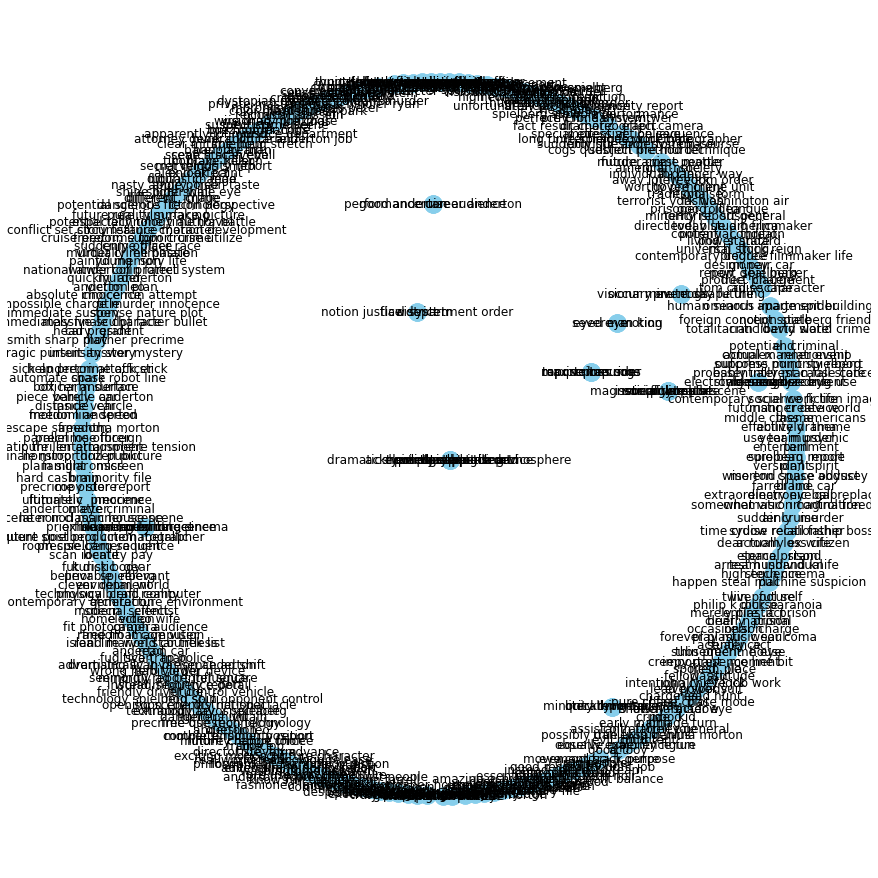

In [39]:
plot_graph(kg_df, use_circular=False)

In [40]:
get_top_sources_and_targets(kg_df)

[('spielberg', 7),
 ('minority report', 5),
 ('crime', 4),
 ('anderton', 4),
 ('thing', 3),
 ('pre  cogs', 2),
 ('cruise', 2),
 ('flaw system', 2),
 ('eye', 2),
 ('message', 2)]

In [41]:
get_top_edges(kg_df, 20)

[('play', 6),
 ('believe', 5),
 ('find', 4),
 ('carry', 3),
 ('include', 3),
 ('create', 3),
 ('prove', 3),
 ('begin', 3),
 ('use', 3),
 ('tend', 2),
 ('think', 2),
 ('set', 2),
 ('determine', 2),
 ('come', 2),
 ('consider', 2),
 ('view', 2),
 ('remind', 2),
 ('willing', 2),
 ('perform', 2),
 ('suppose', 2)]

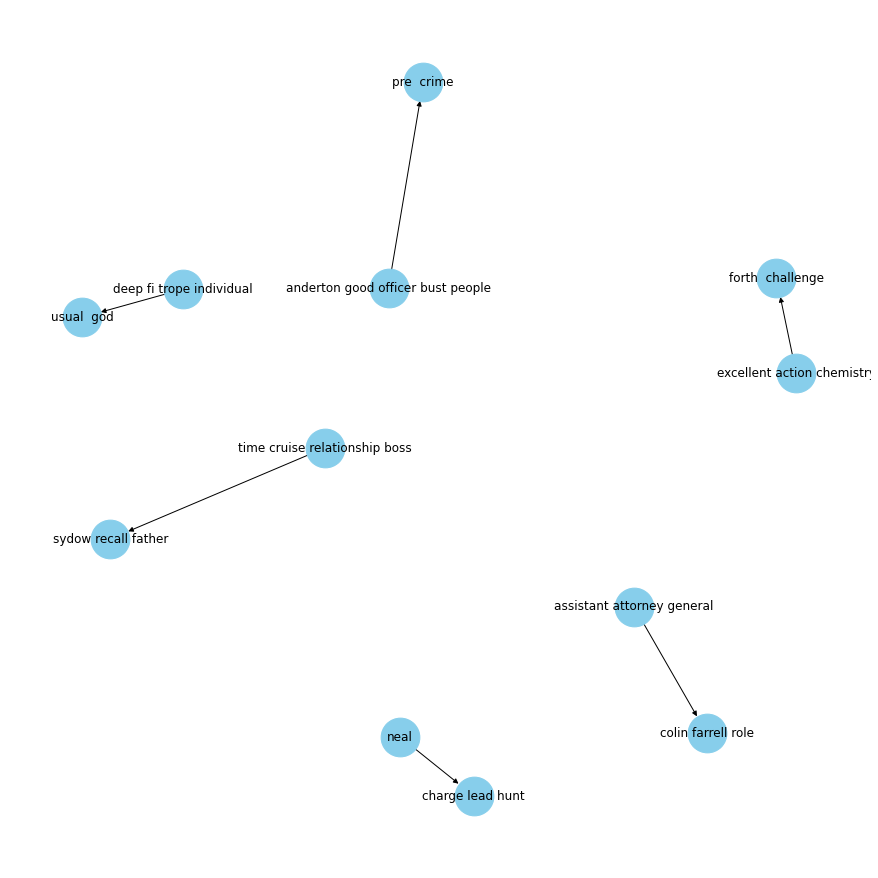

In [42]:
# input relationship in edge== to see a smaller graph
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="play"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

In [43]:
kg_df

source                   target  \
1                                 year murder         use team psychic   
6                               ability drama       effectively  theme   
7                                       theme   middle class americans   
11                              manner device  futuristic create world   
12   contemporary science fiction imagination         social work life   
..                                        ...                      ...   
531                          farrell line car                    brand   
533                      morton cruise abduct   wise end space odyssey   
534                                     plant         version l spirit   
535                          spielberg report           european  mode   
542                             entertainment                    peril   

              edge  
1        eliminate  
6             hold  
7             tend  
11           think  
12             set  
..             ...  
531          build  
533  resemble wise  
534           tend  
535   end american  
542         ignore  

[256 rows x 3 columns]

In [44]:
mrdf = kg_df[kg_df['source']=="minority report"]

In [45]:
spielbergdf = kg_df[kg_df['source']=="spielberg"]

In [46]:
crimedf = kg_df[kg_df['source']=="crime"]

In [47]:
anew_df = mrdf.append(spielbergdf).append(crimedf)
anew_df

source                                target             edge
13   minority report                       social  creator     reveal great
36   minority report                       social  impulse            carry
68   minority report                    issue police state          provide
311  minority report             magnetic fight club scene  appeal superior
518  minority report                               private          suspect
27         spielberg                           idea appeal             find
33         spielberg                    simply state thing            exist
231        spielberg                short story launch pad      complicated
281        spielberg            acknowledge picture device            adapt
289        spielberg                   pointless plot item     turn central
392        spielberg  dramatic element suspense atmosphere             pull
393        spielberg                  type masterpiece art              let
194            crime                        max von murder             wipe
498            crime                      tap pre tap cogs          prevent

In [48]:
nx.get_edge_attributes(G,'edge')

{('deep fi trope individual', 'usual  god', 0): 'play',
 ('anderton good officer bust people', 'pre  crime', 0): 'play',
 ('excellent action chemistry', 'forth  challenge', 0): 'play',
 ('assistant attorney general', 'colin farrell role', 0): 'play',
 ('neal', 'charge lead hunt', 0): 'play',
 ('time cruise relationship boss', 'sydow recall father', 0): 'play'}

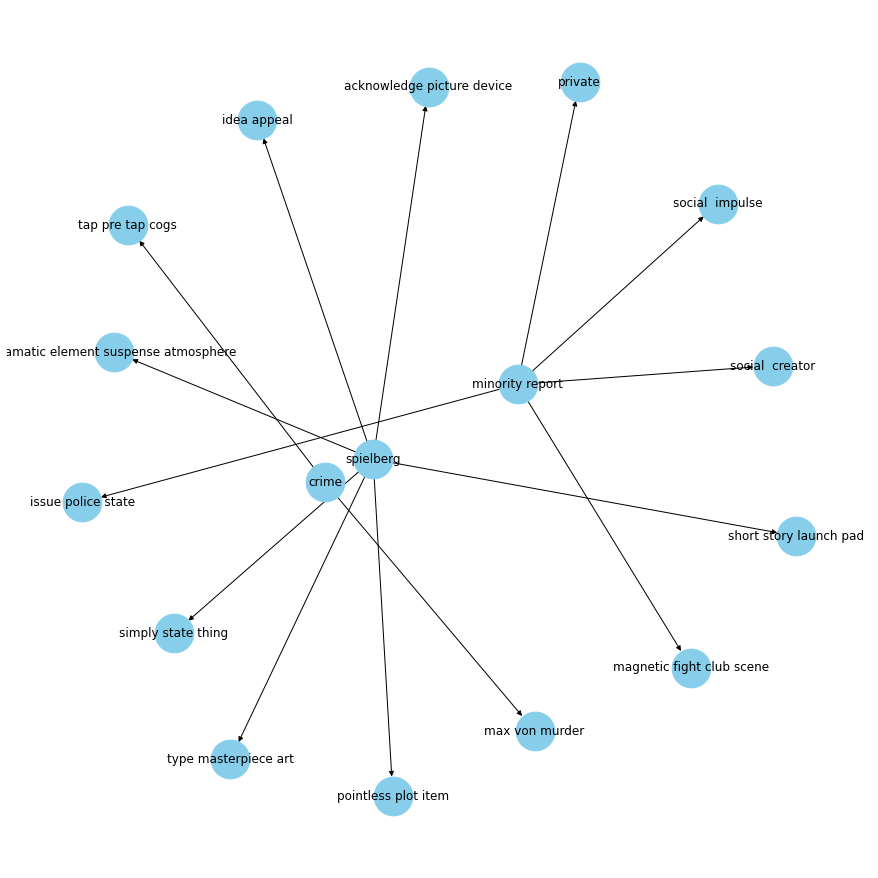

In [49]:
# input relationship in edge== to see a smaller graph
G=nx.from_pandas_edgelist(anew_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
# nx.draw_networkx_edge_labels(G,pos,edge_labels=nx.get_edge_attributes(G,'edge'))
plt.show()

## A plotly example

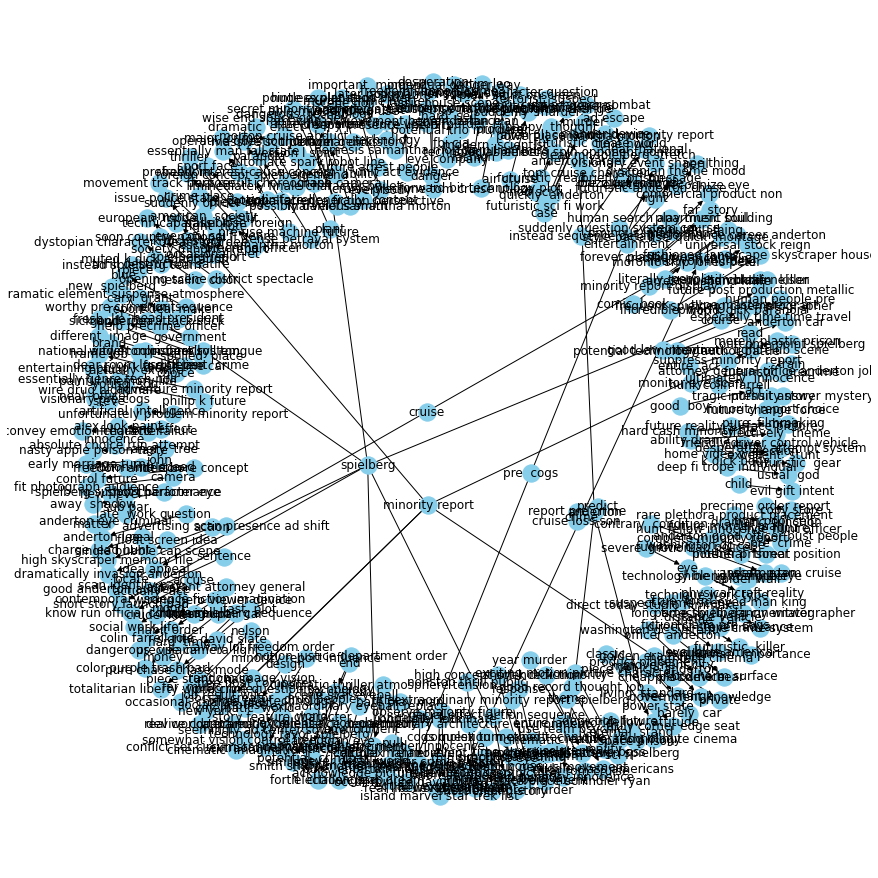

In [50]:
import plotly.graph_objects as go
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())
                          

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

In [51]:
# G.nodes

https://www.kaggle.com/code/anand0427/network-graph-with-at-t-data-using-plotly/notebook

In [52]:
# positions of nodes
pos = nx.spring_layout(G, k=0.5, iterations=50)

In [53]:
# Adding positions of the nodes to the graph
for n, p in pos.items():
    G.nodes[n]['pos'] = p

In [54]:
# plot with plotly
edge_trace = go.Scatter(
    x=[],
    y=[],
    line=dict(width=0.5,color='#888'),
    hoverinfo='none',
    mode='lines')

for edge in G.edges():
    x0, y0 = G.nodes[edge[0]]['pos']
    x1, y1 = G.nodes[edge[1]]['pos']
    edge_trace['x'] += tuple([x0, x1, None])
    edge_trace['y'] += tuple([y0, y1, None])

In [55]:
node_trace = go.Scatter(
    x=[],
    y=[],
    text=[],
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        colorscale='RdBu',
        reversescale=True,
        color=[],
        size=15,
        colorbar=dict(
            thickness=10,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line=dict(width=0)))

for node in G.nodes():
    x, y = G.nodes[node]['pos']
    node_trace['x'] += tuple([x])
    node_trace['y'] += tuple([y])

In [56]:
# !pip install jupyterlab "ipywidgets>=7.5"

In [57]:
for node, adjacencies in enumerate(G.adjacency()):
    node_trace['marker']['color']+=tuple([len(adjacencies[1])])
    node_info = adjacencies[0] +' # of connections: '+str(len(adjacencies[1]))
    node_trace['text']+=tuple([node_info])

In [58]:
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
import plotly.offline as pyo
pyo.init_notebook_mode()
fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title='<br>network connections',
                titlefont=dict(size=16),
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                annotations=[ dict(
                    text="No. of connections",
                    showarrow=False,
                    xref="paper", yref="paper") ],
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)))

# iplot(fig)
# Plot it and save as basic-line.html
pyo.plot(fig, filename = 'Test-bar.html', auto_open = True)
# plotly.plot(fig)

# Show HTML
from IPython.display import HTML
HTML(filename='Test-bar.html')

## Recurrent Neural Network (RNN) Model Development

<img src="https://github.com/djp840/MSDS_453_Public/blob/main/images/BidirectionalRNN.png?raw=true">

<div class="alert alert-block alert-info">
    <b>tf.keras.layers.Bidirectional</b><br>
    https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional
    </div>

In [96]:
datafull=corpus_df.copy() 
datafull.reset_index(drop=True, inplace=True)
datafull.head().T

0  \
DSI_Title                                           KCM_Doc1_AngelHasFallen   
Text                      Boredom sets in long before the start of Angel...   
Submission File Name                                KCM_Doc1_AngelHasFallen   
Student Name                                                            KCM   
Genre of Movie                                                       Action   
Review Type (pos or neg)                                           Negative   
Movie Title                                                Angel Has Fallen   
Descriptor                                     Action_Angel Has Fallen_N_40   
Doc_ID                                                                   40   
raw_sentences             [Boredom sets in long before the start of Ange...   
lemmas                    [set, long, start, angel, fallen, start, journ...   
lemmas_joined             set long start angel fallen start journey chan...   
sentences_lemmatized      [set long start angel fallen, start journey ch...   

                                                                          1  \
DSI_Title                                           KCM_Doc2_AngelHasFallen   
Text                        Who ARE all these people?   That was what I ...   
Submission File Name                                KCM_Doc2_AngelHasFallen   
Student Name                                                            KCM   
Genre of Movie                                                       Action   
Review Type (pos or neg)                                           Negative   
Movie Title                                                Angel Has Fallen   
Descriptor                                     Action_Angel Has Fallen_N_41   
Doc_ID                                                                   41   
raw_sentences             [  Who ARE all these people?   , That was what...   
lemmas                    [people, enter, angel, fallen, local, cinema, ...   
lemmas_joined             people enter angel fallen local cinema sunny l...   
sentences_lemmatized      [people, enter angel fallen local cinema, sunn...   

                                                                          2  \
DSI_Title                                           KCM_Doc3_AngelHasFallen   
Text                      Ric Roman Waugh s Angel Has Fallen sees U.S. S...   
Submission File Name                                KCM_Doc3_AngelHasFallen   
Student Name                                                            KCM   
Genre of Movie                                                       Action   
Review Type (pos or neg)                                           Negative   
Movie Title                                                Angel Has Fallen   
Descriptor                                     Action_Angel Has Fallen_N_42   
Doc_ID                                                                   42   
raw_sentences             [Ric Roman Waugh s Angel Has Fallen sees U.S. ...   
lemmas                    [ric, roman, waugh, angel, fallen, secret, ser...   
lemmas_joined             ric roman waugh angel fallen secret service ag...   
sentences_lemmatized      [ric roman waugh angel fallen secret service a...   

                                                                          3  \
DSI_Title                                           KCM_Doc4_AngelHasFallen   
Text                      There is a certain mindless pleasure in the Fa...   
Submission File Name                                KCM_Doc4_AngelHasFallen   
Student Name                                                            KCM   
Genre of Movie                                                       Action   
Review Type (pos or neg)                                           Negative   
Movie Title                                                Angel Has Fallen   
Descriptor                                     Action_Angel Has Fallen_N_43   
Doc_ID                                    

In [97]:
datafull['Text'] = datafull['Text'].apply(lambda x :clean_doc(x))

### Preprocess DataSet 

In [98]:
data = datafull[['Text','Genre of Movie']].copy()

In [99]:
data['Genre of Movie'] = data['Genre of Movie'].astype("category")
data['Genre of Movie code'] = data['Genre of Movie'].cat.codes
data['Genre of Movie code'].tail().T

195    3
196    3
197    3
198    3
199    3
Name: Genre of Movie code, dtype: int8

In [100]:
features, targets = data['Text'], data['Genre of Movie code']
 
train_features, test_features, train_targets, test_targets = train_test_split(features
                                                                              ,targets
                                                                              ,test_size=0.20
                                                                              ,random_state=42
                                                                              ,shuffle = True
                                                                              ,stratify=targets)
data[["Genre of Movie","Genre of Movie code"]].value_counts()

Genre of Movie  Genre of Movie code
Action          0                      50
Comedy          1                      50
Horror          2                      50
Sci-Fi          3                      50
dtype: int64

### Create Datasets for Model Development

In [101]:
trainds, valds, testds = get_dataset_partitions_pd(data[['Text','Genre of Movie code']])
trainds.shape, valds.shape, testds.shape

((160, 2), (20, 2), (20, 2))

In [102]:
testds

Text  Genre of Movie code
82   Say animated Dr. Aki Ross Final Fantasy , comp...                    1
13   After reading amazing review seeing score 9.3 ...                    0
104  When I elementary school , classmate named Don...                    2
117  If saw Netflix 's recent `` The Tinder Swindle...                    2
128  Why Pennywise clown terrifying It Chapter Two ...                    2
74   The start Holmes & Watson cynical inexplicable...                    1
118  The opening credit Fresh n't arrive 33-minute ...                    2
162  Equilibrium movie search plot . Writer/directo...                    3
141  Is doppelg nger going kill I shower Jordan Pee...                    2
133  Four crazed teenager speed road car , wildly b...                    2
180  Only recently , Tom Cruise looked attempting g...                    3
49   On first day taxi driver , wild Belle find cli...                    0
22   For whose cinematic consciousness predates Sta...                    0
176  In movie future ( 2054 ) see Washington D.C. s...                    3
76   One year critically shellacked movie ( pro for...                    1
3    There certain mindless pleasure Fallen movie ....                    0
130  I say positive thing The Toxic Avenger knew . ...                    2
134  In world movie , many know main genre cover ki...                    2
155  When Warner Brothers announced going make `` B...                    3
75   Many distinguished actor played Sherlock Holme...                    1

### Convert DataFrame to TensorFlow DataSet

In [103]:
# train X & y
train_text_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(trainds['Text'].values, tf.string)
) 
train_cat_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(trainds['Genre of Movie code'].values, tf.int64),
  ) 
# test X & y
test_text_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(testds['Text'].values, tf.string)
) 
test_cat_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(testds['Genre of Movie code'].values, tf.int64),
)
#val X & Y
val_text_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(valds['Text'].values, tf.string)
) 
val_cat_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(valds['Genre of Movie code'].values, tf.int64),
)

### Create DataSets (X=Preprocessed Text, Y=Encoded Categories)

In [104]:
train_ds = tf.data.Dataset.zip(
    (
            train_text_ds_raw,
            train_cat_ds_raw
     )
)
test_ds = tf.data.Dataset.zip(
    (
            test_text_ds_raw,
            test_cat_ds_raw
     )
)
val_ds = tf.data.Dataset.zip(
    (
            val_text_ds_raw,
            val_cat_ds_raw
     )
)

### Create Data Pipelines (Batching, Shuffling, and Optimizing)

In [105]:
batch_size = 5 # was 3 originally
AUTOTUNE = tf.data.experimental.AUTOTUNE
buffer_size=train_ds.cardinality().numpy()

train_ds = train_ds.shuffle(buffer_size=buffer_size)\
                   .batch(batch_size=batch_size,drop_remainder=True)\
                   .cache()\
                   .prefetch(AUTOTUNE)

test_ds = test_ds.shuffle(buffer_size=buffer_size)\
                   .batch(batch_size=batch_size,drop_remainder=True)\
                   .cache()\
                   .prefetch(AUTOTUNE)


val_ds = val_ds.shuffle(buffer_size=buffer_size)\
                   .batch(batch_size=batch_size,drop_remainder=True)\
                   .cache()\
                   .prefetch(AUTOTUNE)

In [106]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   Text                 200 non-null    object  
 1   Genre of Movie       200 non-null    category
 2   Genre of Movie code  200 non-null    int8    
dtypes: category(1), int8(1), object(1)
memory usage: 2.3+ KB


### Create the Text Encoder

The raw text loaded by `tfds` needs to be processed before it can be used in a model. The simplest way to process text for training is using the `experimental.preprocessing.TextVectorization` layer. This layer has many capabilities, but this tutorial sticks to the default behavior.

Create the layer, and pass the dataset's text to the layer's `.adapt` method:
The processing of each sample contains the following steps:

    standardize each sample (usually lowercasing + punctuation stripping)
    split each sample into substrings (usually words)
    recombine substrings into tokens (usually ngrams)
    index tokens (associate a unique int value with each token)
    transform each sample using this index, either into a vector of ints or a dense float vector.

<div class="alert alert-block alert-info">
    <b>tf.keras.layers.TextVectorization</b><br>
   https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization
    </div>

In [107]:
VOCAB_SIZE=5000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE, standardize="lower_and_strip_punctuation", pad_to_max_tokens= True)
encoder.adapt(train_ds.map(lambda text, label: text), batch_size= None)

In [108]:
vocab = np.array(encoder.get_vocabulary())
len(vocab)

5000

In [109]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 's', 'the', 'film', 'i', 'movie', 'one', 'it', 'like',
       'time', 'get', 'make', 'nt', 'character', 'even', 'but', 'scene',
       'much', 'way'], dtype='<U19')

In [110]:
vocab[-20:]

array(['tomatoes', 'toddler', 'tipped', 'tinkering', 'tinge', 'tina',
       'times', 'timeless', 'ticking', 'thwarted', 'thump', 'thrust',
       'thrower', 'threestar', 'threatened', 'thirty', 'thirsty',
       'thirdact', 'thereof', 'thematic'], dtype='<U19')

#### Example of Encoded Words

In [111]:
encoded_example = encoder('encanto we dont talk about bruno no no').numpy()
encoded_example[:]

array([   1,  153,    1,  840, 3701,    1,  116,  116])

In [112]:
len(encoder.get_vocabulary())

5000

In [113]:
encoder(data['Text'][0])

<tf.Tensor: shape=(500,), dtype=int64, numpy=
array([   1,   54,   82,  109,  294,  230,  196,    5,  109, 2069,    6,
       2946,   42, 2502,   56, 2150,  216,   56,  664,    9, 2121, 2642,
       2953,    1,  218,    1,    1, 3202,    1,    5,  677,    1, 3063,
        365, 1459,    1,  611,    5,   69,   56,  756, 3782,    9,   55,
         20,    6,    1,  105, 4396,  105,   69, 1213,  105,  204,  105,
       1213,    8,  517,    7,  473,  976, 3289,  108,    1,   99, 4011,
       1688,   96,   37, 1191,  239,  294,  230,  196,  635,  459,   33,
         37, 1191,   26,  307,    6,   80, 1036,  625,   37, 1343,  242,
         83, 2479,   26, 1252,  394,  415,    1,  289,  195,   33,  274,
       1688, 1298,  159,  517,  596, 2502, 2536,  108,  184,  596,  770,
        737,   95, 3007, 3258,  359,    5,   61,  485,  897, 1357, 3335,
          5,  283,  484,  274,  204,    5, 3107, 1357,    1, 4606,   27,
         39, 2415,    1, 1135, 2643,  299, 1013, 1916,    5, 2125,    5,
     

In [114]:
for example, label in train_ds.take(1):
  print('texts: ', example.numpy()[:1])
  print()

texts:  [b'The theatrical release Batman celebrates 30 year year hold product era regard cinematic entertainment . A brief prologue introduces u Wayne family cutting present day . Gotham City mayor Borg ( Lee Wallace ) want city safer . This task fall upon District Attorney Harvey Dent ( Billy Dee Williams ) Police Commissioner Jim Gordon ( Pat Hingle ) . Unbeknownst , Gotham new vigilante parading around town form Batman ( Bruce Wayne ) . Amid rumor Dark Knight , photojournalist Vicki Vale ( Kim Basinger ) reporter Alexander Knox ( Robert Wuhl ) start investigate existence . Corrupt police officer working mob bring rise Jack Napier aka Joker ( Jack Nicholson ) . In running theme many Batman villain , Napier fall chemical go mad . Ever playmate , Bruce start relationship Vicki whole work thing always manages get way . I really spoil rest 30 year . Once upon time , would best film depicting Dark Knight . This longer case Christopher Nolan phenomenal trilogy . It funny film coming along 

## Build RNN Sequential Model - genre

<div class="alert alert-block alert-info">
    <b>tf.keras.layers</b><br>
    https://www.tensorflow.org/api_docs/python/tf/keras/layers
    </div>

### model 1

In [115]:
num_classes=4 # updated from 5
model=tf.keras.Sequential([encoder
   ,tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True)
   ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True, dropout=0.3))
   ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,dropout=0.3))
   ,tf.keras.layers.Dense(64, activation='relu')
   ,tf.keras.layers.Dense(num_classes,activation='softmax')  
])

In [116]:
model.compile(optimizer= tf.keras.optimizers.Adam( )
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() 
              ,metrics=['accuracy'])

In [117]:
%%time
history = model.fit(train_ds
         ,epochs=200
         ,validation_data=val_ds
         ,validation_steps=3
         ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)])

Epoch 1/200
32/32 [==============================] - 22s 249ms/step - loss: 1.3848 - accuracy: 0.2812 - val_loss: 1.3917 - val_accuracy: 0.2000
Epoch 2/200
32/32 [==============================] - 3s 104ms/step - loss: 1.2180 - accuracy: 0.4688 - val_loss: 0.9550 - val_accuracy: 0.5333
Epoch 3/200
32/32 [==============================] - 3s 104ms/step - loss: 0.6273 - accuracy: 0.7000 - val_loss: 1.6121 - val_accuracy: 0.4000
Epoch 4/200
32/32 [==============================] - 3s 104ms/step - loss: 0.6005 - accuracy: 0.7500 - val_loss: 0.7422 - val_accuracy: 0.6667
Epoch 5/200
32/32 [==============================] - 3s 104ms/step - loss: 0.2438 - accuracy: 0.9062 - val_loss: 0.8422 - val_accuracy: 0.6667
Epoch 6/200
32/32 [==============================] - 3s 103ms/step - loss: 0.0410 - accuracy: 1.0000 - val_loss: 0.6531 - val_accuracy: 0.7333
Epoch 7/200
32/32 [==============================] - 3s 103ms/step - loss: 0.0520 - accuracy: 0.9875 - val_loss: 1.8369 - val_accuracy: 0.400

### Model Performance Test Accuracy

In [118]:
test_loss, test_acc = model.evaluate(val_ds)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

4/4 [==============================] - 0s 48ms/step - loss: 0.7006 - accuracy: 0.7000
Test Loss: 0.7006245255470276
Test Accuracy: 0.699999988079071


### Plotting Performance Metrics - Multi-Layer Bidirectional RNN

In [119]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [120]:
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

loss  accuracy  val_loss  val_accuracy
3  0.600     0.750     0.742         0.667
4  0.244     0.906     0.842         0.667
5  0.041     1.000     0.653         0.733
6  0.052     0.988     1.837         0.400
7  0.121     0.950     0.746         0.667

In [121]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

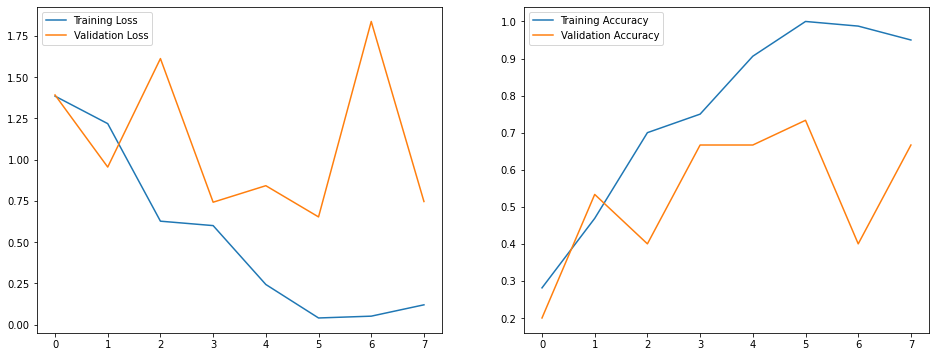

In [122]:
plt.figure(figsize=(16, 6))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

### Confusion Matrix Post Model Performance Analysis

In [123]:
preds2 = model.predict(test_ds)
y_pred2 = np.argmax(preds2, axis=1)
y2 = np.concatenate([y for x, y in test_ds], axis=0)

4/4 [==============================] - 5s 45ms/step


In [124]:
y_pred2

array([3, 3, 1, 3, 2, 0, 0, 3, 1, 3, 0, 3, 3, 0, 2, 3, 3, 1, 0, 3])

In [125]:
y2

array([1, 3, 1, 3, 2, 0, 0, 2, 2, 1, 0, 3, 2, 0, 2, 2, 1, 2, 2, 3])

In [126]:
CLASSES_LIST = ['Action','Comedy','Horror','Sci Fi']

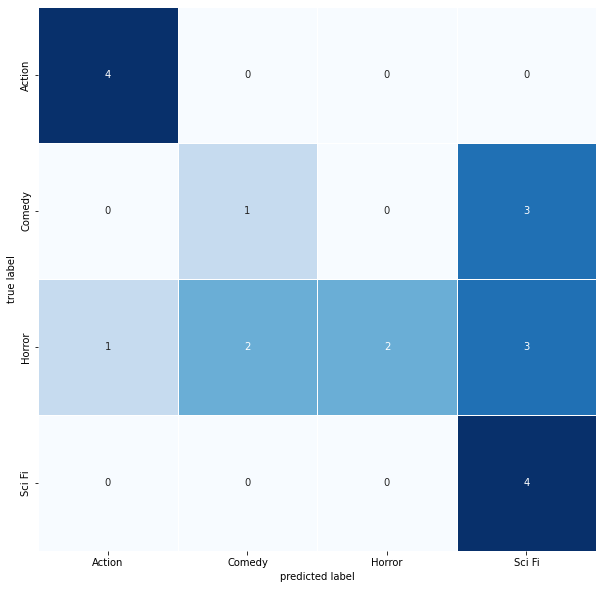

In [127]:
plot_confusion_matrix_labeled(y2,y_pred2, CLASSES_LIST=CLASSES_LIST)

In [128]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)

In [129]:
df2 = pd.DataFrame(preds2[0:20]
                  ,columns = CLASSES_LIST).T
df2.style.format("{:.2%}").background_gradient(cmap=cm)

In [130]:
# testds

In [131]:
testds['pred1'] = y_pred2
testds

Text  Genre of Movie code  \
82   Say animated Dr. Aki Ross Final Fantasy , comp...                    1   
13   After reading amazing review seeing score 9.3 ...                    0   
104  When I elementary school , classmate named Don...                    2   
117  If saw Netflix 's recent `` The Tinder Swindle...                    2   
128  Why Pennywise clown terrifying It Chapter Two ...                    2   
74   The start Holmes & Watson cynical inexplicable...                    1   
118  The opening credit Fresh n't arrive 33-minute ...                    2   
162  Equilibrium movie search plot . Writer/directo...                    3   
141  Is doppelg nger going kill I shower Jordan Pee...                    2   
133  Four crazed teenager speed road car , wildly b...                    2   
180  Only recently , Tom Cruise looked attempting g...                    3   
49   On first day taxi driver , wild Belle find cli...                    0   
22   For whose cinematic consciousness predates Sta...                    0   
176  In movie future ( 2054 ) see Washington D.C. s...                    3   
76   One year critically shellacked movie ( pro for...                    1   
3    There certain mindless pleasure Fallen movie ....                    0   
130  I say positive thing The Toxic Avenger knew . ...                    2   
134  In world movie , many know main genre cover ki...                    2   
155  When Warner Brothers announced going make `` B...                    3   
75   Many distinguished actor played Sherlock Holme...                    1   

     pred  
82      3  
13      3  
104     1  
117     3  
128     2  
74      0  
118     0  
162     3  
141     1  
133     3  
180     0  
49      3  
22      3  
176     0  
76      2  
3       3  
130     3  
134     1  
155     0  
75      3

### RNN Model Architecture

In [132]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, None)             0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, None, 64)          320000    
                                                                 
 bidirectional_2 (Bidirectio  (None, None, 128)        66048     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                      

### model 2

In [145]:
num_classes=4 # updated from 5
model=tf.keras.Sequential([encoder
   ,tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 128, mask_zero=True)
   ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,  return_sequences=True, dropout=0.3))
   ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,dropout=0.3))
   ,tf.keras.layers.Dense(128, activation='relu')
   ,tf.keras.layers.Dense(num_classes,activation='softmax')  
])

In [146]:
model.compile(optimizer= tf.keras.optimizers.Adam( )
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() 
              ,metrics=['accuracy'])

In [147]:
%%time
history = model.fit(train_ds
         ,epochs=200
         ,validation_data=val_ds
         ,validation_steps=3
         ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)])

Epoch 1/200
32/32 [==============================] - 23s 279ms/step - loss: 1.3856 - accuracy: 0.2812 - val_loss: 1.3810 - val_accuracy: 0.2667
Epoch 2/200
32/32 [==============================] - 4s 138ms/step - loss: 1.1167 - accuracy: 0.5250 - val_loss: 1.1409 - val_accuracy: 0.4000
Epoch 3/200
32/32 [==============================] - 4s 138ms/step - loss: 1.0341 - accuracy: 0.5375 - val_loss: 1.0980 - val_accuracy: 0.5333
Epoch 4/200
32/32 [==============================] - 4s 140ms/step - loss: 0.4759 - accuracy: 0.8313 - val_loss: 0.6788 - val_accuracy: 0.7333
Epoch 5/200
32/32 [==============================] - 4s 139ms/step - loss: 0.4324 - accuracy: 0.8750 - val_loss: 0.8939 - val_accuracy: 0.6667
Epoch 6/200
32/32 [==============================] - 4s 138ms/step - loss: 0.1588 - accuracy: 0.9563 - val_loss: 0.8439 - val_accuracy: 0.7333
CPU times: user 48.7 s, sys: 1.1 s, total: 49.8 s
Wall time: 44.7 s


### Model Performance Test Accuracy

In [148]:
test_loss, test_acc = model.evaluate(val_ds)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

4/4 [==============================] - 0s 69ms/step - loss: 0.6682 - accuracy: 0.8000
Test Loss: 0.6681865453720093
Test Accuracy: 0.800000011920929


### Plotting Performance Metrics - Multi-Layer Bidirectional RNN

In [149]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [150]:
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

loss  accuracy  val_loss  val_accuracy
1  1.117     0.525     1.141         0.400
2  1.034     0.538     1.098         0.533
3  0.476     0.831     0.679         0.733
4  0.432     0.875     0.894         0.667
5  0.159     0.956     0.844         0.733

In [151]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

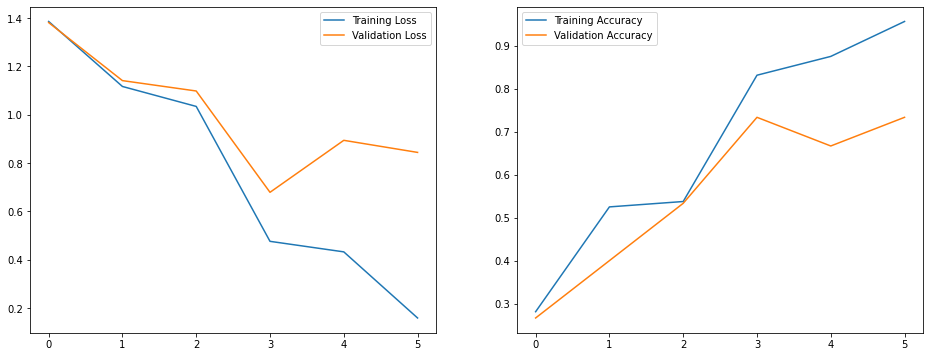

In [152]:
plt.figure(figsize=(16, 6))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

### Confusion Matrix Post Model Performance Analysis

In [153]:
preds2 = model.predict(test_ds)
y_pred2 = np.argmax(preds2, axis=1)
y2 = np.concatenate([y for x, y in test_ds], axis=0)

4/4 [==============================] - 4s 56ms/step


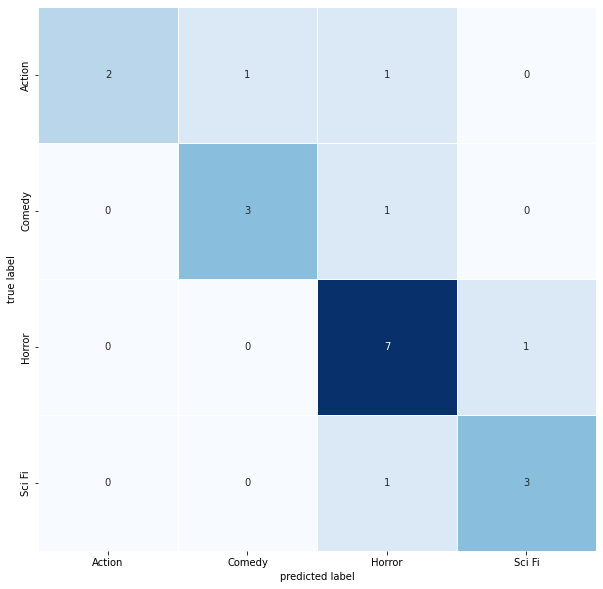

In [154]:
plot_confusion_matrix_labeled(y2,y_pred2, CLASSES_LIST=CLASSES_LIST)

In [155]:
df2 = pd.DataFrame(preds2[0:20]
                  ,columns = CLASSES_LIST).T
df2.style.format("{:.2%}").background_gradient(cmap=cm)

In [156]:
testds['pred2'] = y_pred2
testds

Text  Genre of Movie code  \
82   Say animated Dr. Aki Ross Final Fantasy , comp...                    1   
13   After reading amazing review seeing score 9.3 ...                    0   
104  When I elementary school , classmate named Don...                    2   
117  If saw Netflix 's recent `` The Tinder Swindle...                    2   
128  Why Pennywise clown terrifying It Chapter Two ...                    2   
74   The start Holmes & Watson cynical inexplicable...                    1   
118  The opening credit Fresh n't arrive 33-minute ...                    2   
162  Equilibrium movie search plot . Writer/directo...                    3   
141  Is doppelg nger going kill I shower Jordan Pee...                    2   
133  Four crazed teenager speed road car , wildly b...                    2   
180  Only recently , Tom Cruise looked attempting g...                    3   
49   On first day taxi driver , wild Belle find cli...                    0   
22   For whose cinematic consciousness predates Sta...                    0   
176  In movie future ( 2054 ) see Washington D.C. s...                    3   
76   One year critically shellacked movie ( pro for...                    1   
3    There certain mindless pleasure Fallen movie ....                    0   
130  I say positive thing The Toxic Avenger knew . ...                    2   
134  In world movie , many know main genre cover ki...                    2   
155  When Warner Brothers announced going make `` B...                    3   
75   Many distinguished actor played Sherlock Holme...                    1   

     pred  pred2  
82      3      1  
13      3      3  
104     1      1  
117     3      2  
128     2      2  
74      0      1  
118     0      0  
162     3      2  
141     1      2  
133     3      1  
180     0      0  
49      3      3  
22      3      2  
176     0      2  
76      2      2  
3       3      3  
130     3      2  
134     1      2  
155     0      2  
75      3      3

### model 3

In [221]:
num_classes=4 # updated from 5
model=tf.keras.Sequential([encoder
   ,tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 300, mask_zero=True)
   ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,  return_sequences=True, dropout=0.3))
   ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,dropout=0.3))
   ,tf.keras.layers.Dense(64, activation='relu')
   ,tf.keras.layers.Dense(num_classes,activation='softmax')  
])

In [222]:
model.compile(optimizer= tf.keras.optimizers.Adam( )
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() 
              ,metrics=['accuracy'])

In [223]:
%%time
history = model.fit(train_ds
         ,epochs=200
         ,validation_data=val_ds
         ,validation_steps=3
         ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)])

Epoch 1/200
32/32 [==============================] - 23s 318ms/step - loss: 1.3781 - accuracy: 0.2812 - val_loss: 1.3815 - val_accuracy: 0.4000
Epoch 2/200
32/32 [==============================] - 4s 141ms/step - loss: 0.9926 - accuracy: 0.6938 - val_loss: 1.4081 - val_accuracy: 0.5333
Epoch 3/200
32/32 [==============================] - 4s 141ms/step - loss: 0.5073 - accuracy: 0.8000 - val_loss: 0.8815 - val_accuracy: 0.6667
Epoch 4/200
32/32 [==============================] - 4s 142ms/step - loss: 0.2171 - accuracy: 0.9438 - val_loss: 0.6109 - val_accuracy: 0.8667
Epoch 5/200
32/32 [==============================] - 4s 141ms/step - loss: 0.0518 - accuracy: 0.9875 - val_loss: 0.2947 - val_accuracy: 0.9333
Epoch 6/200
32/32 [==============================] - 4s 141ms/step - loss: 0.0054 - accuracy: 1.0000 - val_loss: 0.2294 - val_accuracy: 0.9333
Epoch 7/200
32/32 [==============================] - 4s 142ms/step - loss: 0.0035 - accuracy: 1.0000 - val_loss: 0.2371 - val_accuracy: 0.933

### Model Performance Test Accuracy

In [224]:
test_loss, test_acc = model.evaluate(val_ds)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

4/4 [==============================] - 0s 71ms/step - loss: 0.1921 - accuracy: 0.9500
Test Loss: 0.1920633763074875
Test Accuracy: 0.949999988079071


### Plotting Performance Metrics - Multi-Layer Bidirectional RNN

In [225]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [226]:
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

loss  accuracy  val_loss  val_accuracy
3  0.217     0.944     0.611         0.867
4  0.052     0.988     0.295         0.933
5  0.005     1.000     0.229         0.933
6  0.003     1.000     0.237         0.933
7  0.003     1.000     0.250         0.933

In [227]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

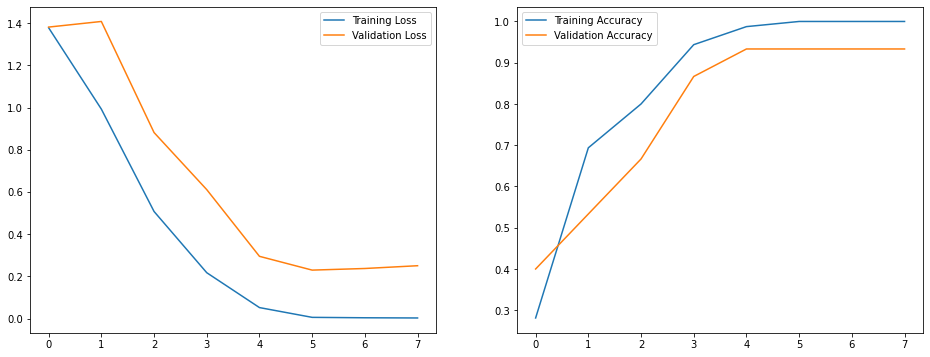

In [228]:
plt.figure(figsize=(16, 6))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

### Confusion Matrix Post Model Performance Analysis

In [229]:
preds2 = model.predict(test_ds)
y_pred2 = np.argmax(preds2, axis=1)
y2 = np.concatenate([y for x, y in test_ds], axis=0)

4/4 [==============================] - 4s 57ms/step


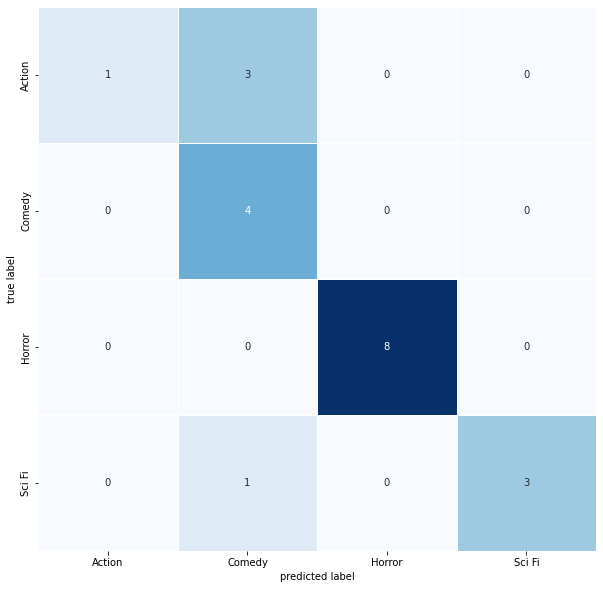

In [230]:
plot_confusion_matrix_labeled(y2,y_pred2, CLASSES_LIST=CLASSES_LIST)

In [231]:
df2 = pd.DataFrame(preds2[0:20]
                  ,columns = CLASSES_LIST).T
df2.style.format("{:.2%}").background_gradient(cmap=cm)

In [232]:
testds['pred3'] = y_pred2
testds

Text  Genre of Movie code  \
82   Say animated Dr. Aki Ross Final Fantasy , comp...                    1   
13   After reading amazing review seeing score 9.3 ...                    0   
104  When I elementary school , classmate named Don...                    2   
117  If saw Netflix 's recent `` The Tinder Swindle...                    2   
128  Why Pennywise clown terrifying It Chapter Two ...                    2   
74   The start Holmes & Watson cynical inexplicable...                    1   
118  The opening credit Fresh n't arrive 33-minute ...                    2   
162  Equilibrium movie search plot . Writer/directo...                    3   
141  Is doppelg nger going kill I shower Jordan Pee...                    2   
133  Four crazed teenager speed road car , wildly b...                    2   
180  Only recently , Tom Cruise looked attempting g...                    3   
49   On first day taxi driver , wild Belle find cli...                    0   
22   For whose cinematic consciousness predates Sta...                    0   
176  In movie future ( 2054 ) see Washington D.C. s...                    3   
76   One year critically shellacked movie ( pro for...                    1   
3    There certain mindless pleasure Fallen movie ....                    0   
130  I say positive thing The Toxic Avenger knew . ...                    2   
134  In world movie , many know main genre cover ki...                    2   
155  When Warner Brothers announced going make `` B...                    3   
75   Many distinguished actor played Sherlock Holme...                    1   

     pred  pred2  pred3  
82      3      1      1  
13      3      3      3  
104     1      1      1  
117     3      2      1  
128     2      2      2  
74      0      1      1  
118     0      0      1  
162     3      2      2  
141     1      2      2  
133     3      1      1  
180     0      0      0  
49      3      3      3  
22      3      2      2  
176     0      2      1  
76      2      2      2  
3       3      3      2  
130     3      2      1  
134     1      2      2  
155     0      2      2  
75      3      3      3

## Sentiment Models

In [234]:
sentiment_data = datafull[['Review Type (pos or neg)', 'Text']]

In [235]:
sentiment_data['Review Type (pos or neg)'] = sentiment_data['Review Type (pos or neg)'].str.lower()

In [236]:
sentiment_data['Review Type (pos or neg)'].value_counts()

negative    100
positive    100
Name: Review Type (pos or neg), dtype: int64

In [237]:
sentiment_data['Review Type (pos or neg)'] = sentiment_data['Review Type (pos or neg)'].astype("category")
sentiment_data['sentiment_code'] = sentiment_data['Review Type (pos or neg)'].cat.codes
sentiment_data.head()

Review Type (pos or neg)                                               Text  \
0                 negative  Boredom set long start Angel Has Fallen . I st...   
1                 negative  Who ARE people ? That I muttered I entered fir...   
2                 negative  Ric Roman Waugh Angel Has Fallen see U.S. Secr...   
3                 negative  There certain mindless pleasure Fallen movie ....   
4                 negative  No , need seen Olympus Has Fallen and/or Londo...   

   sentiment_code  
0               0  
1               0  
2               0  
3               0  
4               0

In [238]:
sentiment_data.tail(5)

Review Type (pos or neg)  \
195                 positive   
196                 positive   
197                 positive   
198                 positive   
199                 positive   

                                                  Text  sentiment_code  
195  It 's Vin Diesel week ! Suddenly , largely unk...               1  
196  Packed razzle-dazzle special effect fueled agg...               1  
197  Richard B. Riddick ( Vin Diesel ) seem remain ...               1  
198  WHAT 'S IT ABOUT ? A passenger spaceship hit r...               1  
199  Sometimes , take movie face value . They ca n'...               1

In [239]:
sentiment_data['sentiment_code'].value_counts()

0    100
1    100
Name: sentiment_code, dtype: int64

In [240]:
sfeatures, stargets = sentiment_data['Text'], sentiment_data['sentiment_code']

In [241]:
strain_features, stest_features, strain_targets, stest_targets = train_test_split(sfeatures, 
                                                                              stargets , 
                                                                              test_size=0.20, 
                                                                              random_state=42, 
                                                                              shuffle=True,
                                                                              stratify=stargets)

In [242]:
strainds, svalds, stestds = get_dataset_partitions_pd(sentiment_data[['Text','sentiment_code']])
strainds.shape, svalds.shape, stestds.shape

((160, 2), (20, 2), (20, 2))

In [243]:
# train X & y
strain_text_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(strainds['Text'].values, tf.string)
) 
strain_cat_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(strainds['sentiment_code'].values, tf.int64),
  ) 
# test X & y
stest_text_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(stestds['Text'].values, tf.string)
) 
stest_cat_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(stestds['sentiment_code'].values, tf.int64),
)
#val X & Y
sval_text_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(svalds['Text'].values, tf.string)
) 
sval_cat_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(svalds['sentiment_code'].values, tf.int64),
)

In [244]:
strain_ds = tf.data.Dataset.zip(
    (
            strain_text_ds_raw,
            strain_cat_ds_raw
     )
)
stest_ds = tf.data.Dataset.zip(
    (
            stest_text_ds_raw,
            stest_cat_ds_raw
     )
)
sval_ds = tf.data.Dataset.zip(
    (
            sval_text_ds_raw,
            sval_cat_ds_raw
     )
)

In [245]:
batch_size = 5
AUTOTUNE = tf.data.experimental.AUTOTUNE
sbuffer_size = strain_ds.cardinality().numpy()

strain_ds = (strain_ds.shuffle(buffer_size=sbuffer_size)
                    .batch(batch_size=batch_size,drop_remainder=True)
                    .cache()
                    .prefetch(AUTOTUNE))

stest_ds = (stest_ds.shuffle(buffer_size=sbuffer_size)
                  .batch(batch_size=batch_size,drop_remainder=True)
                  .cache()
                  .prefetch(AUTOTUNE))

sval_ds = (sval_ds.shuffle(buffer_size=sbuffer_size)
                .batch(batch_size=batch_size,drop_remainder=True)
                .cache()
                .prefetch(AUTOTUNE))

In [247]:
sx_train = strain_features.to_numpy()
sy_train = strain_targets.to_numpy()
sx_test = stest_features.to_numpy()
sy_test = stest_targets.to_numpy()

In [248]:
VOCAB_SIZE = 5000
sencoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE, standardize="lower_and_strip_punctuation", pad_to_max_tokens= True)
sencoder.adapt(strain_ds.map(lambda text, label: text), batch_size= None)

### Model 1

In [249]:
num_classes=2 #
sent_model_1 = tf.keras.Sequential([sencoder,
                             tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 128, mask_zero=True),
                             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True, dropout=0.3)),
                             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, dropout=0.3)),
                             tf.keras.layers.Dense(64, activation='relu'),
                             tf.keras.layers.Dense(1, activation='sigmoid')])

In [250]:
sent_model_1.compile(optimizer= tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=tf.metrics.BinaryAccuracy())

In [251]:
#%%time
shistory = sent_model_1.fit(strain_ds
         ,epochs=20
         ,validation_data=sval_ds
         ,validation_steps=3
         ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='binary_accuracy', patience=3)])

Epoch 1/20
32/32 [==============================] - 23s 326ms/step - loss: 0.6969 - binary_accuracy: 0.4812 - val_loss: 0.6932 - val_binary_accuracy: 0.5333
Epoch 2/20
32/32 [==============================] - 4s 109ms/step - loss: 0.6614 - binary_accuracy: 0.8375 - val_loss: 0.6962 - val_binary_accuracy: 0.5333
Epoch 3/20
32/32 [==============================] - 3s 109ms/step - loss: 0.2488 - binary_accuracy: 0.9500 - val_loss: 1.0324 - val_binary_accuracy: 0.4000
Epoch 4/20
32/32 [==============================] - 3s 108ms/step - loss: 0.1904 - binary_accuracy: 0.9250 - val_loss: 1.3695 - val_binary_accuracy: 0.4000
Epoch 5/20
32/32 [==============================] - 3s 108ms/step - loss: 0.0104 - binary_accuracy: 1.0000 - val_loss: 1.7400 - val_binary_accuracy: 0.4000
Epoch 6/20
32/32 [==============================] - 3s 108ms/step - loss: 0.0013 - binary_accuracy: 1.0000 - val_loss: 1.8821 - val_binary_accuracy: 0.3333
Epoch 7/20
32/32 [==============================] - 3s 108ms/st

### Model Performance Test Accuracy

In [252]:
test_loss, test_acc = sent_model_1.evaluate(sval_ds)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

4/4 [==============================] - 0s 55ms/step - loss: 1.9713 - binary_accuracy: 0.4500
Test Loss: 1.971295952796936
Test Accuracy: 0.44999998807907104


### Plotting Performance Metrics - Multi-Layer Bidirectional RNN

In [253]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [254]:
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

loss  accuracy  val_loss  val_accuracy
3  0.217     0.944     0.611         0.867
4  0.052     0.988     0.295         0.933
5  0.005     1.000     0.229         0.933
6  0.003     1.000     0.237         0.933
7  0.003     1.000     0.250         0.933

In [255]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

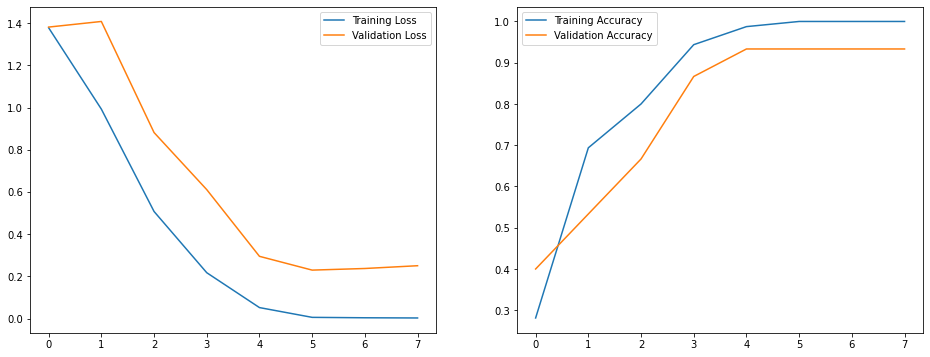

In [256]:
plt.figure(figsize=(16, 6))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

### Confusion Matrix Post Model Performance Analysis

In [260]:
spreds = sent_model_1.predict(stest_ds)
sy_pred = (spreds > 0.5).astype("int32")
sy_1 = np.concatenate([y for x, y in stest_ds], axis=0)

4/4 [==============================] - 5s 49ms/step


In [263]:
CLASS_LIST = ['Positive','Negative']

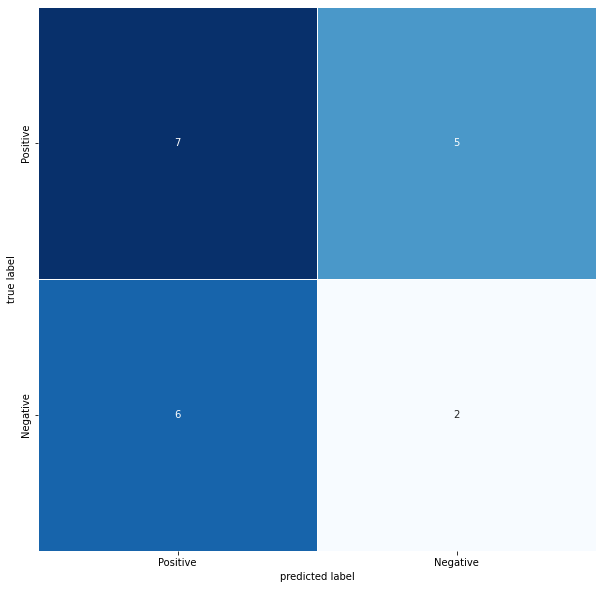

In [264]:
plot_confusion_matrix_labeled(sy_1, sy_pred, CLASSES_LIST=CLASS_LIST)

In [271]:
sy_pred

array([[0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0]], dtype=int32)

In [272]:
stestds['pred1'] = sy_pred
stestds

Text  sentiment_code  pred1
82   Say animated Dr. Aki Ross Final Fantasy , comp...               0      0
13   After reading amazing review seeing score 9.3 ...               0      1
104  When I elementary school , classmate named Don...               0      0
117  If saw Netflix 's recent `` The Tinder Swindle...               1      1
128  Why Pennywise clown terrifying It Chapter Two ...               1      1
74   The start Holmes & Watson cynical inexplicable...               0      1
118  The opening credit Fresh n't arrive 33-minute ...               1      0
162  Equilibrium movie search plot . Writer/directo...               0      1
141  Is doppelg nger going kill I shower Jordan Pee...               0      0
133  Four crazed teenager speed road car , wildly b...               0      0
180  Only recently , Tom Cruise looked attempting g...               0      0
49   On first day taxi driver , wild Belle find cli...               1      0
22   For whose cinematic consciousness predates Sta...               0      1
176  In movie future ( 2054 ) see Washington D.C. s...               1      0
76   One year critically shellacked movie ( pro for...               1      0
3    There certain mindless pleasure Fallen movie ....               0      1
130  I say positive thing The Toxic Avenger knew . ...               0      0
134  In world movie , many know main genre cover ki...               0      0
155  When Warner Brothers announced going make `` B...               1      0
75   Many distinguished actor played Sherlock Holme...               1      0

### Model 2

In [283]:
num_classes=2 #
sent_model_1 = tf.keras.Sequential([sencoder,
                             tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 300, mask_zero=True),
                             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,  return_sequences=True, dropout=0.3)),
                             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, dropout=0.3)),
                             tf.keras.layers.Dense(64, activation='relu'),
                             tf.keras.layers.Dense(1, activation='sigmoid')])

In [284]:
sent_model_1.compile(optimizer= tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=tf.metrics.BinaryAccuracy())

In [285]:
#%%time
shistory = sent_model_1.fit(strain_ds
         ,epochs=20
         ,validation_data=sval_ds
         ,validation_steps=3
         ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='binary_accuracy', patience=3)])

Epoch 1/20
32/32 [==============================] - 22s 276ms/step - loss: 0.6989 - binary_accuracy: 0.5125 - val_loss: 0.6934 - val_binary_accuracy: 0.5333
Epoch 2/20
32/32 [==============================] - 4s 128ms/step - loss: 0.6206 - binary_accuracy: 0.7812 - val_loss: 0.7993 - val_binary_accuracy: 0.5333
Epoch 3/20
32/32 [==============================] - 4s 127ms/step - loss: 0.1756 - binary_accuracy: 0.9688 - val_loss: 1.3882 - val_binary_accuracy: 0.4667
Epoch 4/20
32/32 [==============================] - 4s 127ms/step - loss: 0.0088 - binary_accuracy: 1.0000 - val_loss: 1.1674 - val_binary_accuracy: 0.5333
Epoch 5/20
32/32 [==============================] - 4s 127ms/step - loss: 0.0012 - binary_accuracy: 1.0000 - val_loss: 1.1706 - val_binary_accuracy: 0.6000
Epoch 6/20
32/32 [==============================] - 4s 127ms/step - loss: 6.2654e-04 - binary_accuracy: 1.0000 - val_loss: 1.2470 - val_binary_accuracy: 0.6000
Epoch 7/20
32/32 [==============================] - 4s 127m

### Model Performance Test Accuracy

In [286]:
test_loss, test_acc = sent_model_1.evaluate(sval_ds)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

4/4 [==============================] - 0s 69ms/step - loss: 1.7633 - binary_accuracy: 0.5500
Test Loss: 1.7633062601089478
Test Accuracy: 0.550000011920929


### Plotting Performance Metrics - Multi-Layer Bidirectional RNN

In [287]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [288]:
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

loss  accuracy  val_loss  val_accuracy
3  0.217     0.944     0.611         0.867
4  0.052     0.988     0.295         0.933
5  0.005     1.000     0.229         0.933
6  0.003     1.000     0.237         0.933
7  0.003     1.000     0.250         0.933

In [289]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

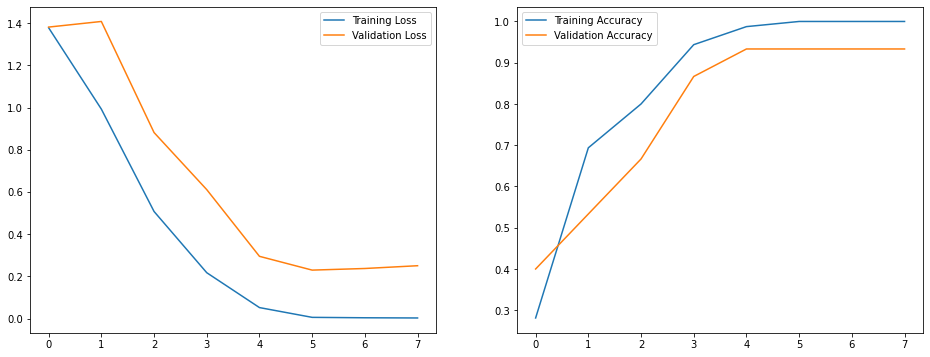

In [290]:
plt.figure(figsize=(16, 6))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

### Confusion Matrix Post Model Performance Analysis

In [291]:
spreds = sent_model_1.predict(stest_ds)
sy_pred = (spreds > 0.5).astype("int32")
sy_1 = np.concatenate([y for x, y in stest_ds], axis=0)

4/4 [==============================] - 7s 60ms/step


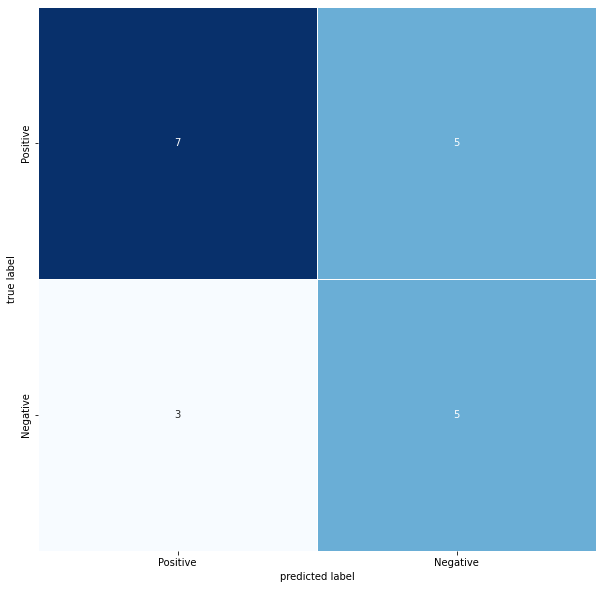

In [292]:
plot_confusion_matrix_labeled(sy_1, sy_pred, CLASSES_LIST=CLASS_LIST)

In [293]:
stestds['pred2'] = sy_pred
stestds

Text  sentiment_code  pred1  \
82   Say animated Dr. Aki Ross Final Fantasy , comp...               0      0   
13   After reading amazing review seeing score 9.3 ...               0      1   
104  When I elementary school , classmate named Don...               0      0   
117  If saw Netflix 's recent `` The Tinder Swindle...               1      1   
128  Why Pennywise clown terrifying It Chapter Two ...               1      1   
74   The start Holmes & Watson cynical inexplicable...               0      1   
118  The opening credit Fresh n't arrive 33-minute ...               1      0   
162  Equilibrium movie search plot . Writer/directo...               0      1   
141  Is doppelg nger going kill I shower Jordan Pee...               0      0   
133  Four crazed teenager speed road car , wildly b...               0      0   
180  Only recently , Tom Cruise looked attempting g...               0      0   
49   On first day taxi driver , wild Belle find cli...               1      0   
22   For whose cinematic consciousness predates Sta...               0      1   
176  In movie future ( 2054 ) see Washington D.C. s...               1      0   
76   One year critically shellacked movie ( pro for...               1      0   
3    There certain mindless pleasure Fallen movie ....               0      1   
130  I say positive thing The Toxic Avenger knew . ...               0      0   
134  In world movie , many know main genre cover ki...               0      0   
155  When Warner Brothers announced going make `` B...               1      0   
75   Many distinguished actor played Sherlock Holme...               1      0   

     pred2  
82       0  
13       0  
104      0  
117      0  
128      0  
74       1  
118      1  
162      0  
141      1  
133      1  
180      1  
49       0  
22       1  
176      0  
76       0  
3        1  
130      1  
134      0  
155      1  
75       1

### Model 3

In [324]:
num_classes=2 #
sent_model_1 = tf.keras.Sequential([sencoder,
                             tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
                             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True, dropout=0.3)),
                             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, dropout=0.3)),
                             tf.keras.layers.Dense(64, activation='relu'),
                             tf.keras.layers.Dense(1, activation='sigmoid')])

In [325]:
sent_model_1.compile(optimizer= tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=tf.metrics.BinaryAccuracy())

In [326]:
#%%time
shistory = sent_model_1.fit(strain_ds
         ,epochs=20
         ,validation_data=sval_ds
         ,validation_steps=3
         ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='binary_accuracy', patience=3)])

Epoch 1/20
32/32 [==============================] - 21s 244ms/step - loss: 0.6974 - binary_accuracy: 0.5063 - val_loss: 0.6938 - val_binary_accuracy: 0.4667
Epoch 2/20
32/32 [==============================] - 3s 99ms/step - loss: 0.6877 - binary_accuracy: 0.6125 - val_loss: 0.6998 - val_binary_accuracy: 0.5333
Epoch 3/20
32/32 [==============================] - 3s 100ms/step - loss: 0.3847 - binary_accuracy: 0.8813 - val_loss: 1.2390 - val_binary_accuracy: 0.4667
Epoch 4/20
32/32 [==============================] - 3s 99ms/step - loss: 0.0104 - binary_accuracy: 1.0000 - val_loss: 2.0938 - val_binary_accuracy: 0.5333
Epoch 5/20
32/32 [==============================] - 3s 98ms/step - loss: 0.0084 - binary_accuracy: 0.9937 - val_loss: 2.0509 - val_binary_accuracy: 0.6000
Epoch 6/20
32/32 [==============================] - 3s 100ms/step - loss: 0.0599 - binary_accuracy: 0.9937 - val_loss: 0.8182 - val_binary_accuracy: 0.6000
Epoch 7/20
32/32 [==============================] - 3s 100ms/step 

### Model Performance Test Accuracy

In [327]:
test_loss, test_acc = sent_model_1.evaluate(sval_ds)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

4/4 [==============================] - 0s 49ms/step - loss: 1.1223 - binary_accuracy: 0.6500
Test Loss: 1.1222654581069946
Test Accuracy: 0.6499999761581421


### Plotting Performance Metrics - Multi-Layer Bidirectional RNN

In [328]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [329]:
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

loss  accuracy  val_loss  val_accuracy
3  0.217     0.944     0.611         0.867
4  0.052     0.988     0.295         0.933
5  0.005     1.000     0.229         0.933
6  0.003     1.000     0.237         0.933
7  0.003     1.000     0.250         0.933

In [330]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

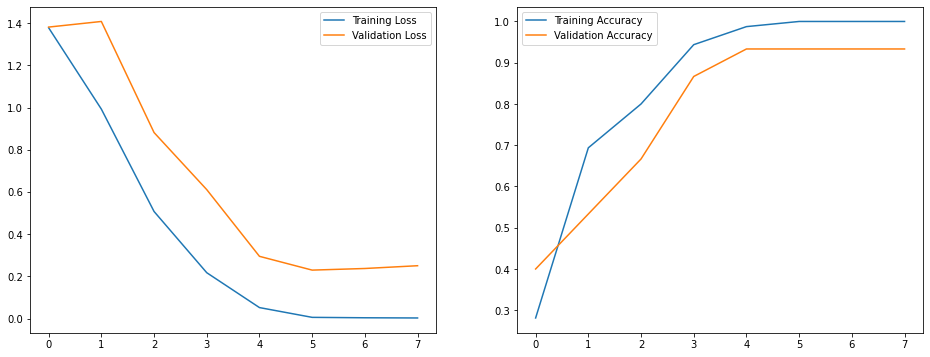

In [331]:
plt.figure(figsize=(16, 6))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

### Confusion Matrix Post Model Performance Analysis

In [332]:
spreds = sent_model_1.predict(stest_ds)
sy_pred = (spreds > 0.5).astype("int32")
sy_1 = np.concatenate([y for x, y in stest_ds], axis=0)

4/4 [==============================] - 5s 49ms/step


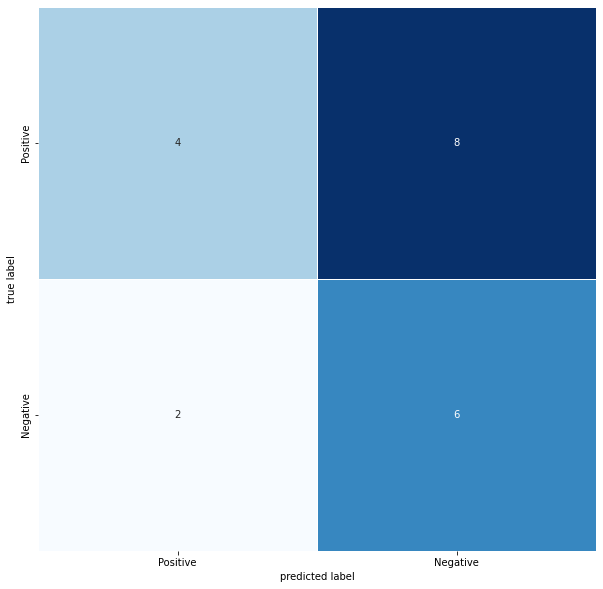

In [333]:
plot_confusion_matrix_labeled(sy_1, sy_pred, CLASSES_LIST=CLASS_LIST)

In [334]:
stestds['pred3'] = sy_pred
stestds

Text  sentiment_code  pred1  \
82   Say animated Dr. Aki Ross Final Fantasy , comp...               0      0   
13   After reading amazing review seeing score 9.3 ...               0      1   
104  When I elementary school , classmate named Don...               0      0   
117  If saw Netflix 's recent `` The Tinder Swindle...               1      1   
128  Why Pennywise clown terrifying It Chapter Two ...               1      1   
74   The start Holmes & Watson cynical inexplicable...               0      1   
118  The opening credit Fresh n't arrive 33-minute ...               1      0   
162  Equilibrium movie search plot . Writer/directo...               0      1   
141  Is doppelg nger going kill I shower Jordan Pee...               0      0   
133  Four crazed teenager speed road car , wildly b...               0      0   
180  Only recently , Tom Cruise looked attempting g...               0      0   
49   On first day taxi driver , wild Belle find cli...               1      0   
22   For whose cinematic consciousness predates Sta...               0      1   
176  In movie future ( 2054 ) see Washington D.C. s...               1      0   
76   One year critically shellacked movie ( pro for...               1      0   
3    There certain mindless pleasure Fallen movie ....               0      1   
130  I say positive thing The Toxic Avenger knew . ...               0      0   
134  In world movie , many know main genre cover ki...               0      0   
155  When Warner Brothers announced going make `` B...               1      0   
75   Many distinguished actor played Sherlock Holme...               1      0   

     pred2  pred3  
82       0      1  
13       0      0  
104      0      0  
117      0      1  
128      0      0  
74       1      1  
118      1      1  
162      0      1  
141      1      0  
133      1      0  
180      1      1  
49       0      1  
22       1      1  
176      0      1  
76       0      1  
3        1      1  
130      1      1  
134      0      0  
155      1      1  
75       1      1